# Australian & New Zealand Road Crash Dataset

## Table of Contents <a class='anchor' id='toc'></a>
[Overview](#overview)

[Data Acquisition](#data-acquisition)
- [New Zealand (NZ)](#data-acquisition-new-zealand)
- [Queensland (QLD)](#data-acquisition-queensland)
- [Western Australia (WA)](#data-acquisition-western-australia)
- [Australian Capital Territory (ACT)](#data-acquisition-ACT)
- [Victoria (VIC) & South Australia (SA)](#data-acquisition-vic-sa)
  - [Victoria (VIC)](#data-acqusition-vic)
  - [South Australia (SA)](#data-acqusition-sa)
- [Tasmania, Northern Territory & New South Wales](#data-acquisition-others)

[Data Exploration](#data-exploration)
- [QLD](#data-exploration-qld)
  - [Five Information Streams Model](#data-exploration-qld-5s) 
- [NZ](#data-exploration-nz)
  - [Five Information Streams Model](#data-exploration-nz-5s) 
- [ACT](#data-exploration-act)
  - [Five Information Streams Model](#data-exploration-act-5s) 
- [WA](#data-exploration-wa)
  - [Five Information Streams Model](#data-exploration-wa-5s) 
- [VIC](#data-exploration-vic)
  - [Transforming (& Correcting) Victorian Map Data](#data-exploration-vic-map-correct)<br>
    -[Effectiveness of the Empirical Correction](#data-exploration-vic-map-correct-analysis)
  - [Five Information Streams Model](#data-exploration-vic-5s) 
- [SA](#data-exploration-sa)
  - [Transforming South Australian Map Data](#data-exploration-sa-map-correct)
  - [Five Information Streams Model](#data-exploration-sa-5s) 

[Data Model](#data-model)
  - [Crash Table](#data-model-crash)
  - [Location Table](#data-model-location)
  - [DateTime Table](#data-model-datetime)
  - [Vehicles Table](#data-model-vehicle)
  - [Casualties Table](#data-model-casualties)
  - [Description Table](#data-model-description)
  
[Data Pipeline](#data-pipeline)
  - [Data Pipeline Process](#data-pipeline-process)
  - [Data Quality Checks](#data-pipeline-quality)
  - [Addressing Other Use Cases](#data-pipeline-other)

## Overview <a class='anchor' id='overview'></a>
This project concerns the aggregation of Australian and New Zealand road crash data from various open data websites. The data.gov.au open data portal provides links to datasets created and maintained by various state authorities within Australia. The data is available in multiple formats and is of varying quality and temporal coverage. 

New Zealand's data is available from the New Zealand Government's open data platform data.govt.nz. This data is available in GeoJSON format.

A centralised dataset would assist the general public and interested researchers understanding factors associated with road accidents in Australia and New Zealand. Researchers from the international community can then access this dataset and cross reference it with other datasets. 

Of particular interest to researchers will be information regarding the location of accidents, types of vehicles involved, casualties, description of the factors which led to the crash and the date and time of the occurence. 

The dataset will ideally be hosted on an open data sharing platform like kaggle. In such a case, the data is intended to be created for transfer to the sharing platform. The most intensive use case envisaged for this dataset is infrequent downloads of the data from the original S3 Storage location. 

In [ ]:
#updating existing packages.
!pip install pandas-profiling
!pip install six --upgrade
!pip install matplotlib --upgrade
!pip install 'pandas>=0.25.3' --upgrade
!pip install numpy --upgrade
!pip install scipy --upgrade
!pip install dask --upgrade
!pip install pyarrow
!pip install s3fs
!pip install geopandas
!pip install pyproj

In [7]:
import boto3
import pandas as pd
import numpy as np
import requests
import geopandas as gpd
import json
import os
import configparser
import pyproj
import seaborn as sns
import matplotlib as mpl
import pandas_profiling

In [3]:
pd.__version__

'0.25.3'

In [5]:
#read in the config file which contains the AWS credentials for the s3 bucket.
config = configparser.ConfigParser()
config.read('config_file.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']
s3_path = config['S3']['S3_BUCKET_PATH']

## Data Acquisition <a class='anchor' id='data-acquisition'></a>
[TOC](#toc)
### New Zealand (NZ) <a class='anchor' id='data-acquisition-new-zealand'></a>
The data source for New Zealand is available in GeoJSON format and contains records going back to around 2000 which have location encoding along with a number of fields pertaining to accident casualties, road conditions and time of occurences. In total, the dataset contains over 674,000 records. GeoPandas will be used to simplify the process of importing the data and saving it to s3 buckets for later use. 

In [43]:
url='http://opendata-nzta.opendata.arcgis.com/datasets/a163c5addf2c4b7f9079f08751bd2e1a_0.geojson'
nz_df = gpd.read_file(url)
nz_df.to_file("s3://udacity-dend-mg/anz-crash/crash_nz/crash_nz.geojson", driver='GeoJSON')

Note that this file was later replaced with a CSV version held in the cloud at the location `s3://udacity-dend-mg/anz-crash/crash_nz/crash_nz.csv`.

### Queensland (QLD) <a class='anchor' id='data-acquisition-queensland'></a>
[TOC](#toc)

Queensland data is available from the Queensland Government's open data portal. This dataset contains over 328,000 records of crashes in Queensland dating between 2001 and 2018. The landing page for this data is available [here](https://www.data.qld.gov.au/dataset/crash-data-from-queensland-roads/resource/e88943c0-5968-4972-a15f-38e120d72ec0). It can be requested in either bulk csv download or through an API. I have elected to use the API as it outputs in JSON which is a format which is reliable and easy to work with.

In [10]:
#qld government website only allows retrieval of records at a rate of 100 per request. It is possible to request more by adding a limit parameter
#however this led to instability and server errors. 100 limit was used. Manage this using an offset variable and loop until completion.
offset = 0
qld_url = f"https://www.data.qld.gov.au/api/3/action/datastore_search?offset={offset}&resource_id=e88943c0-5968-4972-a15f-38e120d72ec0"
r = requests.get(url = qld_url)
qld_df = pd.DataFrame(pd.read_json(r.content.decode())['result']['records'])
while True:
    offset+=100
    #give status updates each 1000 records
    if offset%1000==0:
        print(f"Up to record {offset}")
    qld_url = f"https://www.data.qld.gov.au/api/3/action/datastore_search?offset={offset}&resource_id=e88943c0-5968-4972-a15f-38e120d72ec0"
    r = requests.get(url = qld_url)
    df_delta = pd.DataFrame(pd.read_json(r.content.decode())['result']['records'])
    #once we get to the end, the dataframe contains 0 rows and we can abort.
    if len(df_delta)==0:
        break
    qld_df = pd.concat([qld_df, df_delta])
#once all loaded dump to parequet in s3
qld_df.to_parquet("s3://udacity-dend-mg/anz-crash/crash_qld/crash")

Up to record 1000
Up to record 2000
Up to record 3000
Up to record 4000
Up to record 5000
Up to record 6000
Up to record 7000
Up to record 8000
Up to record 9000
Up to record 10000
Up to record 11000
Up to record 12000
Up to record 13000
Up to record 14000
Up to record 15000
Up to record 16000
Up to record 17000
Up to record 18000
Up to record 19000
Up to record 20000
Up to record 21000
Up to record 22000
Up to record 23000
Up to record 24000
Up to record 25000
Up to record 26000
Up to record 27000
Up to record 28000
Up to record 29000
Up to record 30000
Up to record 31000
Up to record 32000
Up to record 33000
Up to record 34000
Up to record 35000
Up to record 36000
Up to record 37000
Up to record 38000
Up to record 39000
Up to record 40000
Up to record 41000
Up to record 42000
Up to record 43000
Up to record 44000
Up to record 45000
Up to record 46000
Up to record 47000
Up to record 48000
Up to record 49000
Up to record 50000
Up to record 51000
Up to record 52000
Up to record 53000
Up

### Western Australia (WA) <a class='anchor' id='data-acquisition-western-australia'></a>
[TOC](#toc)

Western Australia's data is similar to the New Zealand data in that it is available to the general public in GeoJSON format. This format is easily read by GeoPandas. In total the dataset contains over 158,000 records of crashes occuring in WA from 2013 onwards.

In [15]:
url = 'http://portal-mainroads.opendata.arcgis.com/datasets/cd0b2ef39c6e4e71b1aa922942d316cc_2.geojson'
wa_df = gpd.read_file(url)
wa_df.to_file(s3_path+"/crash_wa/crash_wa.geojson", driver='GeoJSON')

In [19]:
wa_df = wa_df.drop(columns=['geometry'])
wa_df = pd.DataFrame(wa_df)

In [20]:
wa_df.to_parquet(s3_path+'/crash_wa/crash')

### Australian Capital Territory (ACT) <a class='anchor' id='data-acquisition-ACT'></a>
[TOC](#toc)

The ACT makes its data available through the open data portal using a specific api endpoint. The dataset contains over 61,000 crash records from the ACT between 2012 and 2019.

In [40]:
url = 'https://www.data.act.gov.au/resource/6jn4-m8rx.json?$limit=62000'
r = requests.get(url=url)
act_df = pd.read_json(r.content.decode())
act_df.head()

In [41]:
#extract the nested column and drop the "human_address" and original nested column
act_df_loc = pd.DataFrame(act_df['location'].tolist())
act_df_loc = act_df_loc.drop('human_address', axis=1)
act_df = act_df.drop('location', axis=1)

In [42]:
#rejoin and send to s3
act_df = pd.concat([act_df, act_df_loc], axis=1)
act_df.to_parquet("s3://udacity-dend-mg/anz-crash/crash_act/crash")

### Victoria & South Australia (SA) <a class='anchor' id='data-acquisition-vic-sa'></a>
[TOC](#toc)
#### Victorian (VIC) Data  <a class='anchor' id='data-acquisition-vic'></a>
Victorian data is available through the Vioctorian open data portal in a zip file format [here](https://vicroadsopendatastorehouse.vicroads.vic.gov.au/opendata/Road_Safety/ACCIDENT.zip).  The zip file contains a series of CSV files which have been pre-extracted and uploaded to the s3 bucket for this project. The bucket is located at ```s3://udacity-dend-mg/anz-crash/crash_vic```
The main file in the victorian data set (ACCIDENT.csv) contains over 183,000 records of crashes in Victoria.

#### South Australian (SA) Data  <a class='anchor' id='data-acquisition-sa'></a>
South Australian data is available as a series of annual zip files starting from 2012 and ending in 2018. These files are available from the following links

- [2018](https://data.sa.gov.au/data/dataset/21386a53-56a1-4edf-bd0b-61ed15f10acf/resource/45ceb7e8-59bd-4492-b107-8379752ea597/download/road-crash-data-2018.zip)
- [2017](https://data.sa.gov.au/data/dataset/21386a53-56a1-4edf-bd0b-61ed15f10acf/resource/8c4689ce-d3cb-413c-a467-674e00fb9115/download/road-crash-data-2017.zip)
- [2016](https://data.sa.gov.au/data/dataset/21386a53-56a1-4edf-bd0b-61ed15f10acf/resource/ade3f316-3720-4c8f-b0a2-181556ec3cf6/download/road-crash-data-2016.zip)
- [2015](https://data.sa.gov.au/data/dataset/21386a53-56a1-4edf-bd0b-61ed15f10acf/resource/01e6515b-5428-4850-9814-b2a11a177040/download/road-crash-data-2015.zip)
- [2014](https://data.sa.gov.au/data/dataset/21386a53-56a1-4edf-bd0b-61ed15f10acf/resource/ea84f40e-8554-4f8d-bbb4-4f6b5c0ef728/download/road-crash-data-2014.zip)
- [2013](https://data.sa.gov.au/data/dataset/21386a53-56a1-4edf-bd0b-61ed15f10acf/resource/4b2b5c27-98c9-42bd-9352-3e35c4e3fc22/download/road-crash-data-2013.zip)
- [2012](https://data.sa.gov.au/data/dataset/21386a53-56a1-4edf-bd0b-61ed15f10acf/resource/922cd06b-76e4-40bf-a534-ce2f2daae904/download/road-crash-data-2012.zip)

These files have been downloaded from the South Australian open data website, extracted and uploaded to an s3 folder at `s3://udacity-dend-mg/anz-crash/crash_sa`.
Each zip file has been extracted and these have been loaded into a file structure with the format:
```s3://udacity-dend-mg/anz-crash/crash_sa/road-crash-data-{year}``` where year is the year of the dataset.

### Tasmania, Northern Territory & New South Wales <a class='anchor' id='data-acquisition-others'></a>
[TOC](#toc)

Tasmania does not provide access to an open dataset without first requesting this from the dataset owner. As such it will not be used in this project.

Similarly the Northern Territory government does not have an open dataset that is accessable through their open data portal.

The New South Wales government provides a number of data visualisations of crash data through its open data portal but provides no unprocessed dataset for consumption by the general public. 

All three of these jurisdictions have been omitted due to non-availability of suitable raw data sources.

## Data Exploration <a class='anchor' id='data-exploration'></a>
[TOC](#toc)

A key difficulty in producing this dataset is contending with the slight differences across the jurisdictions in question. There is limited commonality between the jurisdictions regarding what data should be included in data uploads regarding crash. A first step will be to evaluate the contents of each dataset to determine what information is common and could be included in a analytical model for researchers.

### Queensland (QLD) <a class='anchor' id='data-exploration-qld'></a>
[TOC](#toc)

The data provided by the Queensland government is contained in a single (after accessing the api to staging - see [here](#data-acquisition-queensland)) JSON file. This file contains the following fields:

In [11]:
qld_df = pd.read_parquet(s3_path+'/crash_qld/crash')
qld_df.dtypes

_id                                  int64
Crash_Ref_Number                     int64
Crash_Severity                      object
Crash_Year                           int64
Crash_Month                         object
Crash_Day_Of_Week                   object
Crash_Hour                           int64
Crash_Nature                        object
Crash_Type                          object
Crash_Longitude_GDA94              float64
Crash_Latitude_GDA94               float64
Crash_Street                        object
Crash_Street_Intersecting           object
State_Road_Name                     object
Loc_Suburb                          object
Loc_Local_Government_Area           object
Loc_Post_Code                       object
Loc_Police_Division                 object
Loc_Police_District                 object
Loc_Police_Region                   object
Loc_Queensland_Transport_Region     object
Loc_Main_Roads_Region               object
Loc_ABS_Statistical_Area_2          object
Loc_ABS_Sta

In [6]:
qld_df.head()

,_id,Crash_Ref_Number,Crash_Severity,Crash_Year,Crash_Month,Crash_Day_Of_Week,Crash_Hour,Crash_Nature,Crash_Type,Crash_Longitude_GDA94,...,Count_Casualty_MedicallyTreated,Count_Casualty_MinorInjury,Count_Casualty_Total,Count_Unit_Car,Count_Unit_Motorcycle_Moped,Count_Unit_Truck,Count_Unit_Bus,Count_Unit_Bicycle,Count_Unit_Pedestrian,Count_Unit_Other
0,95471,95471,Medical treatment,2006,August,Friday,9,Overturned,Single Vehicle,152.826688,...,1,0,1,1,0,0,0,0,0,0
1,95472,95472,Property damage only,2006,August,Friday,13,Sideswipe,Multi-Vehicle,152.694329,...,0,0,0,2,0,1,0,0,0,0
2,95473,95473,Hospitalisation,2006,August,Friday,10,Hit object,Single Vehicle,152.661661,...,0,0,1,1,0,0,0,0,0,0
3,95474,95474,Medical treatment,2006,August,Saturday,11,Hit pedestrian,Hit pedestrian,152.998441,...,1,0,1,1,0,0,0,0,1,0
4,95475,95475,Hospitalisation,2006,August,Saturday,16,Hit object,Single Vehicle,152.966149,...,0,0,1,0,1,0,0,0,0,0


#### Five Information Streams Model <a class='anchor' id='data-exploration-qld-5s'></a>
[TOC](#toc)

In general, the QLD crash data can be broken down into five types of information:
1. Crash Location
  - Crash_Longitude_GDA94' 
  - Crash_Latitude_GDA94
  - Crash_Street
  - Crash_Street_Intersecting
  - State_Road_Name
  - Loc_Suburb
  - Loc_Local_Government_Area
  - Loc_Post_Code
  - Loc_Police_Division
  - Loc_Police_District
  - Loc_Police_Region
  - Loc_Queensland_Transport_Region
  - Loc_Main_Roads_Region
  - Loc_ABS_Statistical_Area_2
  - Loc_ABS_Statistical_Area_3
  - Loc_ABS_Statistical_Area_4
  - Loc_ABS_Remoteness
  - Loc_State_Electorate
  - Loc_Federal_Electorate
  - Crash_Controlling_Authority
2. Crash Time
  - Crash_Year
  - Crash_Month
  - Crash_Day_Of_Week
  - Crash_Hour
3. Crash Description
  - Crash_Severity
  - Crash_Roadway_Feature
  - Crash_Traffic_Control
  - Crash_Speed_Limit
  - Crash_Road_Surface_Condition
  - Crash_Atmospheric_Condition
  - Crash_Lighting_Condition
  - Crash_Road_Horiz_Align
  - Crash_Road_Vert_Align
  - Crash_DCA_Code
  - Crash_DCA_Description
  - Crash_DCA_Group_Description
  - DCA_Key_Approach_Dir
4. Crash Casualties
  - Count_Casualty_Fatality
  - Count_Casualty_Hospitalised
  - Count_Casualty_MedicallyTreated
  - Count_Casualty_MinorInjury
  - Count_Casualty_Total
5. Crash Vehicles
  - Count_Unit_Car
  - Count_Unit_Motorcycle_Moped
  - Crash_Unit_Truck
  - Crash_Unit_Bus
  - Crash_Unit_Bicycle
  - Crash_Unit_Pedestrian
  - Crash_Unit_Other
  
Interestingly, QLD data does not provide precise date and time information which will significantly hamper joining data on timelines precisely. Instead the QLD data provides year, month, day of week and hour. Specifically, this prohibits analysis of whether crashes are associated with specific holiday events (public holidays, school holidays, festivals etc). 

### New Zealand (NZ) <a class='anchor' id='data-exploration-nz'></a>
[TOC](#toc)

The data from New Zealand is available as a single CSV file. 

In [4]:
nz_df = pd.read_csv(s3_path+'/crash_nz/crash_nz.csv')

In [14]:
nz_df.head()

,X,Y,OBJECTID_1,OBJECTID,crashYear,crashFinan,crashSever,fatalCount,seriousInj,minorInjur,...,moped,motorcycle,otherVehic,schoolBus,suv,taxi,truck,unknownVeh,vanOrUtili,Pedestrian
0,173.914819,-41.282216,670848,5001,2000,1999/2000,M,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,175.065372,-41.120270,670849,5002,2000,1999/2000,S,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,175.059154,-41.125587,670850,5003,2000,1999/2000,S,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,176.682273,-39.618699,670851,5004,2000,1999/2000,M,0,0,1,...,0,1,0,0,0,0,1,0,0,0
4,174.803236,-41.290227,670852,5005,2000,1999/2000,M,0,0,2,...,0,0,0,0,0,0,0,0,0,0


In [7]:
pd.options.display.max_rows = 1000

In [9]:
nz_df.columns

Index(['X', 'Y', 'OBJECTID_1', 'OBJECTID', 'crashYear', 'crashFinan',
       'crashSever', 'fatalCount', 'seriousInj', 'minorInjur', 'multiVehic',
       'holiday', 'regionDesc', 'tlaID', 'tlaName', 'areaUnitID', 'meshblockI',
       'easting', 'northing', 'crashLocat', 'crashLoc_1', 'outdatedLo',
       'crashRPRS', 'intersecti', 'junctionTy', 'cornerRoad', 'crashDirec',
       'crashDista', 'crashRPDir', 'directionR', 'crashRPDis', 'crashSHDes',
       'crashRPSH', 'crashRPNew', 'intersec_1', 'flatHill', 'roadCharac',
       'roadCurvat', 'roadLane', 'roadMarkin', 'roadSurfac', 'roadWet',
       'numberOfLa', 'trafficCon', 'speedLimit', 'advisorySp', 'temporaryS',
       'urban', 'darkLight', 'light', 'streetLigh', 'weatherA', 'weatherB',
       'animals', 'bridge', 'cliffBank', 'debris', 'ditch', 'fence',
       'guardRail', 'houseBuild', 'kerb', 'objectThro', 'other', 'overBank',
       'parkedVehi', 'phoneBoxEt', 'postOrPole', 'roadworks', 'slipFlood',
       'strayAnima', 'traffi

#### Five Information Streams Model <a class='anchor' id='data-exploration-nz-5s'></a>
[TOC](#toc)

The fields provided by the New Zealand government are extensive. Intepretation and modelling of this data is hampered by the fact that the field names appear to have had a strict character limit applied in the extract of the CSV file. Consulting the [source website](https://opendata-nzta.opendata.arcgis.com/datasets/a163c5addf2c4b7f9079f08751bd2e1a_0/data?geometry=172.115%2C-42.432%2C174.643%2C-42.077) allows the field names to be reconstructed. 

The intention here is to map the facts provided by NZ to the same matrix into which the facts provided by the QLD government were mapped to facilitate data modelling. To that end, the fact provided by the NZ government are divided as follows:

1. Crash Location
  - X (longitude)
  - Y (latitude)
  - regionDesc (regionDescription)
  - tlaID (tlaID - note TLA means [Territorial Regional Authority](https://en.wikipedia.org/wiki/Regions_of_New_Zealand#United_councils))
  - tlaName (tlaName)
  - areaUnitID (areaUnitID - note area Unit Id is analogous to Statistical Areas in AU Data)
  - meshblockI (mesh block ID - similar to Statistical areas in AU data)
  - easting (map grid in coordinates)
  - northing (map grid in coordinates)
  - crashLocat (crashLocation)
  - crashLoc_1 (crashLocation_1)
  - outdatedLo (outdatedLocationDescription)
  - crashRPRS (crashRPRS - [Route Position & Reference Station](https://www.nzta.govt.nz/assets/resources/state-highway-database-operation-manual/docs/SM050-manual.pdf))

2. Crash Time
  - crashYear (crashYear)
  - crashFinan (crashFinancialYear
  - holiday (holiday)
  
3. Crash Description
  - crashSever
  - multiVehic
  - intersecti
  - junctionTy
  - cornerRoad
  - crashDirec
  - crashDista
  - crashRPDir
  - directionR
  - crashRPDis
  - crashSHDes
  - crashRPSH
  - crashRPNew
  - intersec_1
  - flatHill
  - roadCharac
  - roadCurvat
  - roadLane
  - roadMarkin
  - roadSurfac
  - roadWet
  - numberOfLa
  - trafficCon
  - speedLimit
  - advisorySp
  - temporaryS
  - urban
  - darkLight
  - light
  - streetLigh
  - weatherA
  - weatherB
4. Crash Casualties
  - fatalCount
  - seriousInj
  - minorInjur
5. Crash Vehicles
  - animals
  - bridge
  - cliffBank
  - debris
  - ditch
  - fence
  - guardRail
  - houseBuild
  - kerb
  - objectThro
  - other
  - overBank
  - parkedVehi
  - phoneBoxEt
  - postOrPole
  - roadworks
  - slipFlood
  - strayAnima
  - trafficIsl
  - trafficSig
  - train
  - tree
  - vehicle
  - waterRiver
  - bicycle
  - bus
  - carStation
  - moped
  - motorcycle
  - otherVehic
  - schoolBus
  - suv
  - taxi
  - truck
  - unknownVeh
  - vanOrUtili
  - Pedestrian

The two fields OBJECTID_1 & OBJECTID appear to be related primary keys. 

There are a number of problems. Most significantly, the NZ data is vastly different in terms of coverage and focus to the Queensland data. A number of variables are simliar:

  - fatalCount = Count_Casualty_Fatality
  - seriousInj = Count_Casualty_Hospitalised
  - ??? = Count_Casualty_MedicallyTreated
  - minorInjur = Count_Casualty_MinorInjury
  - roadCurvat = Crash_Road_Horiz_Align
  - flatHill = Crash_Road_Vert_Align
  
The key difficulty is that the mappings are not precisely one to one between these versions. For example, the QLD dataset deals with the question of road curvature in terms of visibility to the driver, giving encodings of 'Straight', 'Curved - view open', 'Curved - view obscured' or 'Unknown'. In contrast the New Zealand data talks about curvature in terms of severity gradings of Straight Road, Easy Curve, Mooderate Curve, Severe Curve, Unknown. This in practice hampers the comparability of these data sources. 

### ACT <a class='anchor' id='data-exploration-act'></a>
[TOC](#toc)

In [6]:
act_df = pd.read_parquet('s3://udacity-dend-mg/anz-crash/crash_act/crash')

In [13]:
act_df.head()

,crash_id,crash_date,crash_time,suburb_location,x,y,intersection,midblock,crash_direction,crash_severity,lighting_condition,road_condition,weather_condition,:@computed_region_h8vr_r9vc,latitude,longitude
0,1209242,2019-06-17T00:00:00.000,2019-12-01 11:30:00,WESTON,149.051805,-35.341394,NO,YES,North / West bound,Property Damage Only,Daylight,Good dry surface,Fine,85.0,-35.341393840486695,149.05180491123326
1,1209235,2019-06-15T00:00:00.000,2019-12-01 19:00:00,GIRALANG,149.095324,-35.201405,YES,NO,East / West bound,Injury,Dark - good street lighting,Good dry surface,Fine,44.0,-35.20140474557591,149.09532381937305
2,1209213,2019-06-04T00:00:00.000,2019-12-01 08:50:00,PIALLIGO,149.172724,-35.294597,NO,YES,West bound,Property Damage Only,Daylight,Good dry surface,Fine,21.0,-35.29459680781376,149.17272403538018
3,1209219,2019-06-04T00:00:00.000,2019-12-01 15:20:00,GUNGAHLIN,149.129876,-35.184702,NO,YES,South / West bound,Property Damage Only,Daylight,Good dry surface,Fine,89.0,-35.18470175366862,149.12987626122316
4,1209169,2019-04-24T00:00:00.000,2019-12-01 08:10:00,TURNER,149.120302,-35.272828,YES,NO,East / West bound,Injury,Daylight,Good dry surface,Fine,24.0,-35.27282779175493,149.12030231648555


In contrast the data from the ACT is extremely limited in scope. There is no data available for the precise number of casualties and of what type in the dataset. Information regarding the environment in which the crash occured is also very limited. 

In [200]:
act_df.dtypes

crash_id                                int64
crash_date                             object
crash_time                     datetime64[ns]
suburb_location                        object
x                                     float64
y                                     float64
intersection                           object
midblock                               object
crash_direction                        object
crash_severity                         object
lighting_condition                     object
road_condition                         object
weather_condition                      object
:@computed_region_h8vr_r9vc           float64
latitude                               object
longitude                              object
dtype: object

In [34]:
act_df['crash_severity'].unique()

array(['Property Damage Only', 'Injury', 'Fatal'], dtype=object)

#### Five Information Streams Model <a class='anchor' id='data-exploration-act-5s'></a>
[TOC](#toc)

This is mapped as follows to the QLD dataset 5 heads concepts.
1. Crash Location 
  - suburb_location
  - x
  - y
  - latitude
  - longitude
  
2. Crash Time
  - crash_date
  - crash_time

3. Crash Description
  - intersection
  - midblock
  - crash_direction
  - crash_severity
  - lighting_condition
  - road_condition
  - weather_condition

4. Crash Casualties
  - No Data!!!

5. Crash Vehicles
  - No Data!!!


Importantly, the absence of data for two of the key subject areas of information for the crash is significant. Integration of this data may require that the user be aware that there are a number of crash events which will have no or very limited information regarding crash vehicles or casualties.

### WA <a class='anchor' id='data-exploration-wa'></a>
[TOC](#toc)

The WA dataset is provided in the form of GEO-JSON data which has been converted in the data acquisition phase to parquet. 

In [7]:
wa_df = pd.read_parquet('s3://udacity-dend-mg/anz-crash/crash_wa/crash')

In [203]:
wa_df.head()

,OBJECTID,ACC_ID,ROAD_NO,ROAD_NAME,COMMON_ROAD_NAME,CWAY,SLK,INTERSECTION_NO,INTERSECTION_DESC,LONGITUDE,...,ACCIDENT_TYPE,SEVERITY,EVENT_NATURE,EVENT_TYPE,TOTAL_BIKE_INVOLVED,TOTAL_TRUCK_INVOLVED,TOTAL_HEAVY_TRUCK_INVOLVED,TOTAL_MOTOR_CYCLE_INVOLVED,TOTAL_OTHER_VEHICLES_INVOLVED,TOTAL_PEDESTRIANS_INVOLVED
0,11196693,8714778,H007,North West Coastal Hwy,North West Coastal Hwy,S,921.50,None,None,115.686308,...,Midblock,PDO Major,Non Collision,Involving Animal,0,0,0,0,1,0
1,11196694,8714782,H001,Albany Hwy,Shepperton Rd,L,4.90,004122,Albany Hwy & Welshpool Rd & Albany Hwy,115.912986,...,Intersection,Medical,Rear End,None,0,0,0,0,3,0
2,11196695,8714830,H015,Kwinana Fwy,Kwinana Fwy,L,15.00,None,None,115.849329,...,Midblock,Medical,Rear End,None,0,0,0,0,0,0
3,11196696,8714843,H065,Horrie Miller Dr,Horrie Miller Dr,L,0.00,004543,Horrie Miller Dr & Kewdale Rd,115.965999,...,Intersection,Medical,Rear End,None,0,0,0,0,2,0
4,11196697,8717030,1250466,Howe St,Howe St,S,0.260,056703,Howe St & O'Malley St,115.809726,...,Intersection,PDO Minor,Right Turn Thru,None,0,0,0,0,2,0


In [204]:
wa_df.dtypes

OBJECTID                           int64
ACC_ID                             int64
ROAD_NO                           object
ROAD_NAME                         object
COMMON_ROAD_NAME                  object
CWAY                              object
SLK                               object
INTERSECTION_NO                   object
INTERSECTION_DESC                 object
LONGITUDE                        float64
LATITUDE                         float64
CRASH_DATE                        object
CRASH_TIME                       float64
ACCIDENT_TYPE                     object
SEVERITY                          object
EVENT_NATURE                      object
EVENT_TYPE                        object
TOTAL_BIKE_INVOLVED                int64
TOTAL_TRUCK_INVOLVED               int64
TOTAL_HEAVY_TRUCK_INVOLVED         int64
TOTAL_MOTOR_CYCLE_INVOLVED         int64
TOTAL_OTHER_VEHICLES_INVOLVED      int64
TOTAL_PEDESTRIANS_INVOLVED         int64
dtype: object

#### Five Information Streams Model <a class='anchor' id='data-exploration-wa-5s'></a>
[TOC](#toc)

Applying the 5 types of data we found in the QLD data set above to this dataset, we obtain the following mapping:

1. Crash Location
  - LONGITUDE
  - LATITUDE
  - ROAD_NO
  - ROAD_NAME
  - COMMON_ROAD_NAME
  - CWAY
  - SLK
  - INTERSECTION_NO
  - INTERSECTION_DESC
  
2. Crash Time
  - CRASHDATE
  - CRASHTIME
  
3. Crash Description
  - ACCIDENT_TYPE
  - SEVERITY
  - EVENT_NATURE
  - EVENT_TYPE
4. Crash Casualties
  - NO DATA!!!
5. Crash Vehicles
  - TOTAL_BIKE_INVOLVED
  - TOTAL_TRUCK_INVOLVED
  - TOTAL_HEAVY_TRUCK_INVOLVED
  - TOTAL_MOTOR_CYCLE_INVOLVED
  - TOTAL_OTHER_VEHICLES_INVOLVED
  - TOTAL_PEDESTRIANS_INVOLVED
  
Importantly, it appears that the WA government discloses no information regarding the number or type of casualties in a crash. 

### VIC <a class='anchor' id='data-exploration-vic'></a>
[TOC](#toc)

While the Victorian data is available in a number of different files depending upon the pieces of information of interest, the four supplied files which have the most interesting pieces of information for our purposes are:
1. `ACCIDENT.csv`
2. `NODE.csv`
3. `ATMOSPHERIC_COND.csv`
4. `VEHICLE.csv`

`Accident.csv` deals primarily with the accident itself, including providing information regarding the number of casuatlies, time of the incident and code variables.

`NODE.csv` contains information regarding the location of the crash event. Subsequent sections will deal with the problems with this data.

`ATMOSPHERIC_COND.csv` gives information regarding weather conditions at the time of the crash for each accident. 

`VEHICLE.csv` gives information about each vehicle or other object involved in the crash.

It should be noted that despite all of the nasty things I'm about to say about the mapping standard VicRoads has used, the Victorian data is actually a reasonably well structured dataset which appears to have a useable snowflake schema. The Victorian dataset provides much more information than other datasets. The need to re-engineer the dataset is much more about making the dataset work with other jurisdictions than it is about inherent flaws in how the Victorian data is structured.


In [ ]:
vic_df = pd.read_csv('s3://udacity-dend-mg/anz-crash/crash_vic/ACCIDENT.csv')

In [45]:
len(vic_df)

183919

In [6]:
vic_df.head()

,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,DIRECTORY,...,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,NO_PERSONS_NOT_INJ,POLICE_ATTEND,ROAD_GEOMETRY,Road Geometry Desc,SEVERITY,SPEED_ZONE
0,T20060000010,13/01/2006,12:42:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,...,6,0,1,0,5,1,1,Cross intersection,3,60
1,T20060000018,13/01/2006,19:10:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,...,4,0,1,0,3,1,2,T intersection,3,70
2,T20060000022,14/01/2006,12:10:00,7,Fall from or in moving vehicle,7,Saturday,190,FELL IN/FROM VEHICLE,MEL,...,2,1,0,0,1,1,5,Not at intersection,2,100
3,T20060000023,14/01/2006,11:49:00,1,Collision with vehicle,7,Saturday,130,REAR END(VEHICLES IN SAME LANE),MEL,...,2,1,0,0,1,1,2,T intersection,2,80
4,T20060000026,14/01/2006,10:45:00,1,Collision with vehicle,7,Saturday,121,RIGHT THROUGH,MEL,...,3,0,3,0,0,1,5,Not at intersection,3,50


In [196]:
vic_df.dtypes

ACCIDENT_NO             object
ACCIDENTDATE            object
ACCIDENTTIME            object
ACCIDENT_TYPE            int64
Accident Type Desc      object
DAY_OF_WEEK              int64
Day Week Description    object
DCA_CODE                 int64
DCA Description         object
DIRECTORY               object
EDITION                 object
PAGE                    object
GRID_REFERENCE_X        object
GRID_REFERENCE_Y        object
LIGHT_CONDITION          int64
Light Condition Desc    object
NODE_ID                  int64
NO_OF_VEHICLES           int64
NO_PERSONS               int64
NO_PERSONS_INJ_2         int64
NO_PERSONS_INJ_3         int64
NO_PERSONS_KILLED        int64
NO_PERSONS_NOT_INJ       int64
POLICE_ATTEND            int64
ROAD_GEOMETRY            int64
Road Geometry Desc      object
SEVERITY                 int64
SPEED_ZONE               int64
dtype: object

In [4]:
vic_node_df = pd.read_csv('s3://udacity-dend-mg/anz-crash/crash_vic/NODE.csv')

In [8]:
vic_node_df.head()

,ACCIDENT_NO,NODE_ID,NODE_TYPE,AMG_X,AMG_Y,LGA_NAME,Lga Name All,Region Name,Deg Urban Name,Lat,Long,Postcode No
0,T20060000010,43078,I,2519154.655,2390265.154,DANDENONG,DANDENONG,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-37.98862,145.21805,3175
1,T20060000018,29720,N,2524272.743,2389996.817,CASEY,CASEY,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,NaN,NaN,3804
2,T20060000022,203074,N,2487321.693,2345019.925,MORNINGTON PENINSULA,MORNINGTON PENINSULA,METROPOLITAN SOUTH EAST REGION,RURAL_VICTORIA,NaN,NaN,3939
3,T20060000023,55462,I,2512734.120,2390214.959,DANDENONG,"DANDENONG,KINGSTON",METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-1.00000,-1.00000,3173
4,T20060000026,202988,N,2488777.663,2347612.069,MORNINGTON PENINSULA,MORNINGTON PENINSULA,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-38.37299,144.87159,3940


In [42]:
vic_node_df.dtypes

ACCIDENT_NO        object
NODE_ID             int64
NODE_TYPE          object
AMG_X             float64
AMG_Y             float64
LGA_NAME           object
Lga Name All       object
Region Name        object
Deg Urban Name     object
Lat               float64
Long              float64
Postcode No         int64
calc_lat          float64
calc_long         float64
dtype: object

In [50]:
len(vic_node_df[['ACCIDENT_NO','NODE_ID','NODE_TYPE']].drop_duplicates())

183089

#### Transforming (& Correcting) Victorian Map Data <a class='anchor' id='data-exploration-vic-map-correct'></a>
[TOC](#toc)

The Victorian dataset provides its geospatial location information in two formats:

1. Latitude and Longitude
2. Pseudo-AMG map grid coordinates.

Unfortunately, the latitude and longitude information is very very frequently null in the dataset. Additionally, it appears that in many cases values of -1 and 1 appear in the dataset which is simply not credible. In contrast, the Pseudo-AMG coordinates are always supplied. This coordinate system is obscure in the extreme and appears to be a mapping standard invented by the Victorian Government in the 1980s and abandoned by all but VicRoads who created the dataset. 

In order to provide meaningful location information for non-GIS users, the position information provided by VicRoads in its NODE.csv folder must be converted to a latitude and longitude coordinate system. The data is specified x and y coordinates in meters using a (significantly) modified version of the 1966 edition of the Australian Mapping Geodesic (AMG66). Conversion from one coordinate system to another (in our case standard lat/long data which is standard `epsg:4326`), it is necesary to use a python wrapper to the `Proj` library called `pyproj`. This system allows a string to be used specifying the type of projection and any corrections.

A specification for the projection system used in the Victorian data needs to be provided in the form of a `proj` string. The specification below was provided in the appendix to the data dictionary located [here](http://data.vicroads.vic.gov.au/metadata/crashstats_user_guide_and_appendices.pdf): 

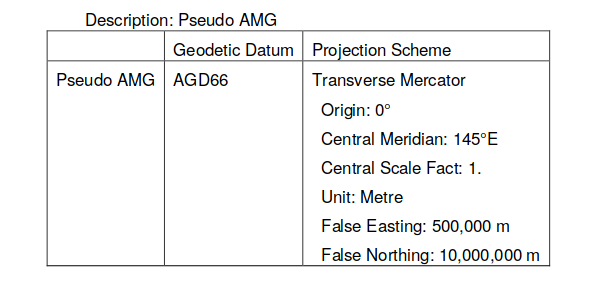

This specification does not match the data and cannot be used to provide correct coordinates. Using this specification, the author of [this](http://nyalldawson.net/2013/05/vicroads-and-pseudo-amg/) website purports to have found a way to make this conversion work. However, applying the supplied `proj` string does not produce sensible coordinates (they are located in the far southern parts of the pacific ocean (near Antarctica)).

Instead, I have referred back to [the original mapping standard](https://www.icsm.gov.au/datum/australian-geodetic-datum-196684-agd) to get the semi-major axis (a), the semi-minor axis (b) and the flatening of the elipsoid (f = 1/298.25) upon which the projection was based. I have then empirically modified the false eastings and northings provided to produce (approximately) correct results when a map grid coordinate is converted into the a known gps coordinate it produces approximately correct results. See below for quantification of error calculations:

In [7]:
#create coordinate reference systems and projection objects to pass to the transformer.
vic_crs = pyproj.CRS.from_string("""+proj=tmerc 
                                    +lat_0=0 
                                    +lon_0=145 
                                    +k=1
                                    +x_0=2500000 
                                    +y_0=6596534.558457338
                                    +f=0.003352891869237217
                                    +a=6378160
                                    +b=6356774.719
                                    +no_defs""")
vic_proj = pyproj.Proj(vic_crs)
gps_proj = pyproj.Proj('epsg:4326')

In [8]:
#generate the transformer object. 
pseudo_amg_to_latlong=pyproj.Transformer.from_proj(vic_proj, gps_proj)

In [9]:
# get rows of vic_node_df where the longitude and latitude data isn't (-1,-1) or nans.
has_neg_1_latitude = vic_node_df['Lat']==-1
has_null_latitude = vic_node_df['Lat'].isna()
has_neg_1_longitude = vic_node_df['Long']==-1
has_null_longitude = vic_node_df['Long'].isna()

vic_node_test_df = vic_node_df[~(has_neg_1_latitude | has_null_latitude | has_neg_1_longitude | has_null_longitude)]
vic_node_test_df.head()

,ACCIDENT_NO,NODE_ID,NODE_TYPE,AMG_X,AMG_Y,LGA_NAME,Lga Name All,Region Name,Deg Urban Name,Lat,Long,Postcode No
0,T20060000010,43078,I,2519154.655,2390265.154,DANDENONG,DANDENONG,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-37.98862,145.21805,3175
4,T20060000026,202988,N,2488777.663,2347612.069,MORNINGTON PENINSULA,MORNINGTON PENINSULA,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-38.37299,144.87159,3940
5,T20060000028,277431,N,2508117.150,2363427.158,MORNINGTON PENINSULA,MORNINGTON PENINSULA,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-38.23045,145.09302,3931
7,T20060000042,203047,N,2514148.093,2371918.397,FRANKSTON,FRANKSTON,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-38.15068,145.15000,3199
8,T20060000044,35621,I,2519124.787,2388749.445,DANDENONG,DANDENONG,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-38.00230,145.21780,3175


In [127]:
#define converter object and apply to generate coordinates
pseudo_amg_to_latlong_obj = pyproj.Transformer.from_proj(vic_proj, gps_proj)

def pseudo_amg_to_latlong(df):
    (lat,long) = pseudo_amg_to_latlong_obj.transform(df['AMG_X'], df['AMG_Y'])
    return lat, long

#apply converter to generate series
latlong_series = vic_node_test_df.apply(pseudo_amg_to_latlong, axis=1)

In [158]:
vic_node_test_df.describe()

,NODE_ID,AMG_X,AMG_Y,Lat,Long,Postcode No,calc_lat,calc_long,delta_lat,delta_long
count,95941.000000,9.594100e+04,9.594100e+04,95941.000000,95941.000000,95941.000000,95941.000000,95941.000000,95941.000000,9.594100e+04
mean,191575.863843,2.497415e+06,2.419672e+06,-37.721322,144.971825,3307.694906,-37.721242,144.971763,-0.000080,6.113010e-05
std,131561.053053,6.960082e+04,6.184295e+04,0.559917,0.783725,302.779708,0.559737,0.783633,0.012189,2.006361e-02
min,4.000000,2.129608e+06,2.274524e+06,-39.023990,140.934810,3000.000000,-39.023861,140.966357,-2.158023,-1.903299e+00
25%,44315.000000,2.487773e+06,2.393397e+06,-37.959740,144.861210,3073.000000,-37.959594,144.861105,-0.000055,-3.718935e-05
50%,233473.000000,2.501512e+06,2.409105e+06,-37.818830,145.017200,3175.000000,-37.818708,145.017179,-0.000017,1.358508e-07
75%,306012.000000,2.517722e+06,2.421313e+06,-37.707980,145.201480,3549.000000,-37.707892,145.201416,0.000013,3.603208e-05
max,598079.000000,2.920148e+06,2.814630e+06,-34.120040,149.757510,3996.000000,-34.122376,149.753482,0.649532,2.971324e+00


In [128]:
#get calculated values and put back into test df.
lat_series = latlong_series.copy().apply(lambda x: x[0])
long_series = latlong_series.copy().apply(lambda x: x[1])
vic_node_test_df.loc[:,'calc_lat'] = lat_series.copy()
vic_node_test_df.loc[:,'calc_long'] = long_series.copy()

#calculate deltas - loc and copy used to suppress pandas warning.
vic_node_test_df.loc[:,'delta_lat'] = vic_node_test_df['Lat'].copy()-vic_node_test_df['calc_lat'].copy()
vic_node_test_df.loc[:,'delta_long'] = vic_node_test_df['Long'].copy()-vic_node_test_df['calc_long'].copy()


/home/mitchell/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/mitchell/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [172]:
#Examine the delta values to determine if there is anything unaccounted for in them - we're looking for approximately 0 residuals with a small spread. 
vic_node_test_df[['delta_lat', 'delta_long']].describe()

,delta_lat,delta_long
count,95941.000000,9.594100e+04
mean,-0.000080,6.113010e-05
std,0.012189,2.006361e-02
min,-2.158023,-1.903299e+00
25%,-0.000055,-3.718935e-05
50%,-0.000017,1.358508e-07
75%,0.000013,3.603208e-05
max,0.649532,2.971324e+00


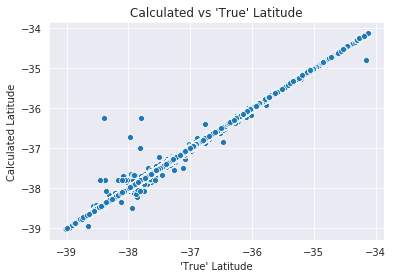

In [145]:
#plot the calculated series and the deltas against the provided data
%matplotlib inline
sns.set_style("darkgrid")
fig = sns.scatterplot(x=vic_node_test_df['Lat'], y=vic_node_test_df['calc_lat'])
mpl.pyplot.title("Calculated vs 'True' Latitude")
mpl.pyplot.xlabel("'True' Latitude")
mpl.pyplot.ylabel("Calculated Latitude")
mpl.pyplot.show(fig)

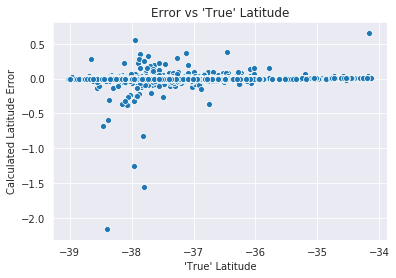

In [147]:
ax2 = sns.scatterplot(x=vic_node_test_df['Lat'], y=vic_node_test_df['delta_lat'])
ax2.set_title("Error vs 'True' Latitude")
ax2.set_xlabel("'True' Latitude")
ax2.set_ylabel("Calculated Latitude Error")
mpl.pyplot.show()

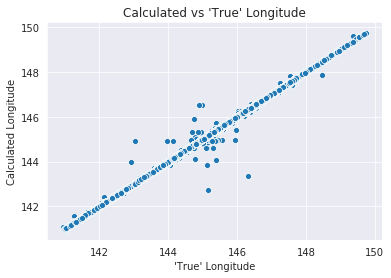

In [148]:
ax3 = sns.scatterplot(x=vic_node_test_df['Long'], y=vic_node_test_df['calc_long'])
ax3.set_title("Calculated vs 'True' Longitude")
ax3.set_xlabel("'True' Longitude")
ax3.set_ylabel("Calculated Longitude")
mpl.pyplot.show()

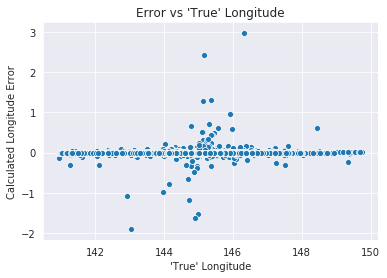

In [150]:
sns.set_style("darkgrid")
ax4 = sns.scatterplot(x=vic_node_test_df['Long'], y=vic_node_test_df['delta_long'])
ax4.set_title("Error vs 'True' Longitude")
ax4.set_xlabel("'True' Longitude")
ax4.set_ylabel("Calculated Longitude Error")
mpl.pyplot.show()

##### Effectiveness of the Correction <a class='anchor' id='data-exploration-vic-map-correct-analysis'></a>
[TOC](#toc)

The figures above appear to indicate that the transformation applied produces a very good approximation to the known coordinates. There are some large variances but these do not appear to be induced by a systematic fault with the transformation applied but may rather reflect a fault with the supplied "true" lat long positions by VicRoads. The middle 50% of the data (between Q1 and Q3) has a deviation from the provided information of less than 0.0001 of a degree. This arc represents approximately 10m in each direction. 

Additionally, when the residuals (errors) are considered, the line is flat with no systematic variation around the horizontal which indicates that there is no variance in the calculated values as a function of an error in the transform. This is as cloase as I can reasonably get this with the information available.

These coordinates should be sufficient for approximately locating crash events in the dataset. I note that a number of authors advise that this mapping standard (even without modification) has been known to produce variances of up to 200m. See for example [here](https://www.icsm.gov.au/datum/australian-geodetic-datum-196684-agd).

In [11]:
#apply to the remainder of the dataset.
latlong_series = vic_node_df.apply(pseudo_amg_to_latlong, axis=1)

In [12]:
#get calculated values and put back into df.
lat_series = latlong_series.copy().apply(lambda x: x[0])
long_series = latlong_series.copy().apply(lambda x: x[1])
vic_node_df.loc[:,'calc_lat'] = lat_series.copy()
vic_node_df.loc[:,'calc_long'] = long_series.copy()


In [217]:
vic_node_df.head()

,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,DIRECTORY,...,NO_PERSONS,NO_PERSONS_INJ_2,NO_PERSONS_INJ_3,NO_PERSONS_KILLED,NO_PERSONS_NOT_INJ,POLICE_ATTEND,ROAD_GEOMETRY,Road Geometry Desc,SEVERITY,SPEED_ZONE
0,T20060000010,13/01/2006,12:42:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,...,6,0,1,0,5,1,1,Cross intersection,3,60
1,T20060000018,13/01/2006,19:10:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,...,4,0,1,0,3,1,2,T intersection,3,70
2,T20060000022,14/01/2006,12:10:00,7,Fall from or in moving vehicle,7,Saturday,190,FELL IN/FROM VEHICLE,MEL,...,2,1,0,0,1,1,5,Not at intersection,2,100
3,T20060000023,14/01/2006,11:49:00,1,Collision with vehicle,7,Saturday,130,REAR END(VEHICLES IN SAME LANE),MEL,...,2,1,0,0,1,1,2,T intersection,2,80
4,T20060000026,14/01/2006,10:45:00,1,Collision with vehicle,7,Saturday,121,RIGHT THROUGH,MEL,...,3,0,3,0,0,1,5,Not at intersection,3,50


In [83]:
#merge with primary dataset
vic_merge_df = vic_df.merge(vic_node_df, how='left', on='ACCIDENT_NO')

In [84]:
#attempting to write back induced a failure as a result of encoding of some fields. Coercing to strings to suppress error.
vic_merge_df['EDITION'] = vic_merge_df['EDITION'].apply(str)
vic_merge_df['GRID_REFERENCE_Y'] = vic_merge_df['GRID_REFERENCE_Y'].apply(str)


In [85]:
vic_atmos_df = pd.read_csv('s3://udacity-dend-mg/anz-crash/crash_vic/ATMOSPHERIC_COND.csv')

In [32]:
vic_atmos_df.head()

,ACCIDENT_NO,ATMOSPH_COND,ATMOSPH_COND_SEQ,Atmosph Cond Desc
0,T20060000010,1,1,Clear
1,T20060000018,1,1,Clear
2,T20060000022,1,1,Clear
3,T20060000023,1,1,Clear
4,T20060000026,1,1,Clear


In [86]:
vic_merge_df = vic_merge_df.merge(vic_atmos_df, on = 'ACCIDENT_NO', how='left')

In [7]:
#Read in vehicle types
vic_vehic_df = pd.read_csv("s3://udacity-dend-mg/anz-crash/crash_vic/VEHICLE.csv")

/home/mitchell/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3,25,26,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
vic_vehic_df.head()

,ACCIDENT_NO,VEHICLE_ID,VEHICLE_YEAR_MANUF,VEHICLE_DCA_CODE,INITIAL_DIRECTION,ROAD_SURFACE_TYPE,Road Surface Type Desc,REG_STATE,VEHICLE_BODY_STYLE,VEHICLE_MAKE,...,VEHICLE_COLOUR_1,VEHICLE_COLOUR_2,CAUGHT_FIRE,INITIAL_IMPACT,LAMPS,LEVEL_OF_DAMAGE,OWNER_POSTCODE,TOWED_AWAY_FLAG,TRAFFIC_CONTROL,Traffic Control Desc
0,T20060000010,A,1996.0,2,SW,1,Paved,V,SEDAN,MITSUB,...,MRN,ZZ,2,F,2,3,3130.0,1,1,Stop-go lights
1,T20060000010,B,2003.0,1,NW,1,Paved,V,COUPE,UNKN,...,BLU,ZZ,2,2,2,3,3977.0,1,1,Stop-go lights
2,T20060000010,C,2001.0,8,NW,1,Paved,V,SEDAN,FORD,...,YLW,ZZ,2,F,2,2,3804.0,2,1,Stop-go lights
3,T20060000018,A,1998.0,2,S,1,Paved,V,DC UTE,TOYOTA,...,GRY,ZZ,2,9,0,3,3175.0,1,0,No control
4,T20060000018,B,1991.0,1,N,1,Paved,V,SEDAN,SUBARU,...,BLU,ZZ,2,F,0,5,3805.0,1,11,Giveway sign


In [19]:
vic_vehic_df.dtypes

ACCIDENT_NO                object
VEHICLE_ID                 object
VEHICLE_YEAR_MANUF        float64
VEHICLE_DCA_CODE           object
INITIAL_DIRECTION          object
ROAD_SURFACE_TYPE           int64
Road Surface Type Desc     object
REG_STATE                  object
VEHICLE_BODY_STYLE         object
VEHICLE_MAKE               object
VEHICLE_MODEL              object
VEHICLE_POWER             float64
VEHICLE_TYPE                int64
Vehicle Type Desc          object
VEHICLE_WEIGHT            float64
CONSTRUCTION_TYPE          object
FUEL_TYPE                  object
NO_OF_WHEELS              float64
NO_OF_CYLINDERS           float64
SEATING_CAPACITY          float64
TARE_WEIGHT               float64
TOTAL_NO_OCCUPANTS        float64
CARRY_CAPACITY            float64
CUBIC_CAPACITY             object
FINAL_DIRECTION            object
DRIVER_INTENT              object
VEHICLE_MOVEMENT           object
TRAILER_TYPE               object
VEHICLE_COLOUR_1           object
VEHICLE_COLOUR

In [12]:
vic_vehic_summary_df = (vic_vehic_df
                         [['ACCIDENT_NO', 'Vehicle Type Desc', 'VEHICLE_ID']]
                         .groupby(['ACCIDENT_NO','Vehicle Type Desc'])
                         .count()
                         .rename(columns = {'VEHICLE_ID':'count'})
                         .reset_index()
                         .pivot_table(index = 'ACCIDENT_NO', columns = 'Vehicle Type Desc', values='count', aggfunc = sum, fill_value = 0)
                       )

In [15]:
vic_vehic_summary_df.index

Index(['T20060000010', 'T20060000018', 'T20060000022', 'T20060000023',
       'T20060000026', 'T20060000028', 'T20060000035', 'T20060000042',
       'T20060000044', 'T20060000046',
       ...
       'T20190020760', 'T20190020773', 'T20190021082', 'T20190021105',
       'T20190021116', 'T20190021161', 'T20190021192', 'T20190021272',
       'T20190021300', 'T20190021336'],
      dtype='object', name='ACCIDENT_NO', length=183919)

In [99]:
vic_vehic_summary_df = (vic_vehic_df
                         [['ACCIDENT_NO', 'Vehicle Type Desc', 'VEHICLE_ID']]
                         .groupby(['ACCIDENT_NO','Vehicle Type Desc'])
                         .count()
                         .reset_index()
                         .rename(columns = {'VEHICLE_ID':'count'})
                         .pivot_table(index = 'ACCIDENT_NO', columns = 'Vehicle Type Desc', values=['count'], aggfunc = sum, fill_value = 0)
                         .rename_axis([None,None], axis=1)
                         .reset_index())

In [100]:
vic_vehic_summary_df.columns = ['_'.join(tup).rstrip('_') for tup in vic_vehic_summary_df.columns.values]

In [101]:
vic_vehic_summary_df.head()

,ACCIDENT_NO,count_Bicycle,count_Bus/Coach,count_Car,count_Heavy Vehicle (Rigid) > 4.5 Tonnes,count_Horse (ridden or drawn),count_Light Commercial Vehicle (Rigid) <= 4.5 Tonnes GVM,count_Mini Bus(9-13 seats),count_Moped,count_Motor Cycle,...,count_Prime Mover B-Triple,count_Prime Mover Only,count_Quad Bike,count_Rigid Truck(Weight Unknown),count_Station Wagon,count_Taxi,count_Train,count_Tram,count_Unknown,count_Utility
0,T20060000010,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,T20060000018,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,T20060000022,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,T20060000023,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,T20060000026,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [16]:
vic_vehic_summary_df.dtypes

Vehicle Type Desc
Bicycle                                               int64
Bus/Coach                                             int64
Car                                                   int64
Heavy Vehicle (Rigid) > 4.5 Tonnes                    int64
Horse (ridden or drawn)                               int64
Light Commercial Vehicle (Rigid) <= 4.5 Tonnes GVM    int64
Mini Bus(9-13 seats)                                  int64
Moped                                                 int64
Motor Cycle                                           int64
Motor Scooter                                         int64
Not Applicable                                        int64
Other Vehicle                                         int64
Panel Van                                             int64
Parked trailers                                       int64
Plant machinery and Agricultural equipment            int64
Prime Mover (No of Trailers Unknown)                  int64
Prime Mover - Single T

In [89]:
vic_merge_df = vic_merge_df.merge(vic_vehic_summary_df, how = 'left', on = 'ACCIDENT_NO')

In [91]:
#write back to bucket for staging
vic_merge_df.to_parquet('s3://udacity-dend-mg/anz-crash/crash_vic/vic_crash')

In [3]:
vic_merge_df = pd.read_parquet('s3://udacity-dend-mg/anz-crash/crash_vic/vic_crash')

In [36]:
vic_merge_df.head()

,ACCIDENT_NO,ACCIDENTDATE,ACCIDENTTIME,ACCIDENT_TYPE,Accident Type Desc,DAY_OF_WEEK,Day Week Description,DCA_CODE,DCA Description,DIRECTORY,...,Region Name,Deg Urban Name,Lat,Long,Postcode No,calc_lat,calc_long,ATMOSPH_COND,ATMOSPH_COND_SEQ,Atmosph Cond Desc
0,T20060000010,13/01/2006,12:42:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,...,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-37.98862,145.21805,3175.0,-37.988597,145.218047,1,1,Clear
1,T20060000018,13/01/2006,19:10:00,1,Collision with vehicle,6,Friday,113,RIGHT NEAR (INTERSECTIONS ONLY),MEL,...,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,NaN,NaN,3804.0,-37.990892,145.276317,1,1,Clear
2,T20060000022,14/01/2006,12:10:00,7,Fall from or in moving vehicle,7,Saturday,190,FELL IN/FROM VEHICLE,MEL,...,METROPOLITAN SOUTH EAST REGION,RURAL_VICTORIA,NaN,NaN,3939.0,-38.396322,144.854870,1,1,Clear
3,T20060000023,14/01/2006,11:49:00,1,Collision with vehicle,7,Saturday,130,REAR END(VEHICLES IN SAME LANE),MEL,...,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-1.00000,-1.00000,3173.0,-37.989162,145.144960,1,1,Clear
4,T20060000026,14/01/2006,10:45:00,1,Collision with vehicle,7,Saturday,121,RIGHT THROUGH,MEL,...,METROPOLITAN SOUTH EAST REGION,MELB_URBAN,-38.37299,144.87159,3940.0,-38.372990,144.871578,1,1,Clear


In [94]:
pd.set_option('display.max_rows', 100)
vic_merge_df.dtypes

ACCIDENT_NO                                                  object
ACCIDENTDATE                                                 object
ACCIDENTTIME                                                 object
ACCIDENT_TYPE                                                 int64
Accident Type Desc                                           object
DAY_OF_WEEK                                                   int64
Day Week Description                                         object
DCA_CODE                                                      int64
DCA Description                                              object
DIRECTORY                                                    object
EDITION                                                      object
PAGE                                                         object
GRID_REFERENCE_X                                             object
GRID_REFERENCE_Y                                             object
LIGHT_CONDITION                                 

#### Five Information Streams Model <a class='anchor' id='data-exploration-vic-5s'></a>
[TOC](#toc)

Now that the data are merged together and in one place for us to examine, following the 5 heads of information available from the QLD data, we find the following mapping in the Victorian dataset:
1. Crash Location
  - DIRECTORY
  - EDITION
  - PAGE
  - GRID_REFERENCE_X
  - GRID_REFERENCE_Y
  - NODE_ID
  - NODE_TYPE
  - AMG_X
  - AMG_Y
  - LGA_NAME
  - Lga Name All
  - Region Name
  - Deg Urban Name
  - Lat
  - Long
  - Postcode No
  - calc_lat
  - calc_long
2. Crash Time
  - ACCIDENTDATE
  - ACCIDENTTIME
  - DAY_OF_WEEK
  - Day Week Description
3. Crash Description
  - ACCIDENT_TYPE 
  - Accident Type Desc
  - DCA_CODE
  - DCA Description
  - ATMOSPH_COND
  - ATMOSPH_COND_SEQ
  - Atmosph Cond Desc
  - LIGHT_CONDITION
  - Light Condition Desc
  - POLICE_ATTEND
  - ROAD_GEOMETRY
  - Road Geometry Desc
  - SEVERITY
  - SPEED_ZONE        
4. Crash Casualties
  - NO_PERSONS_INJ_2
  - NO_PERSONS_INJ_3
  - NO_PERSONS_KILLED
  - NO_PERSONS_NOT_INJ
5. Crash Vehicles
  - count_Bicycle
  - count_Bus/Coach
  - count_Car
  - count_Heavy Vehicle (Rigid) > 4.5 Tonnes
  - count_Horse (ridden or drawn)
  - count_Light Commercial Vehicle (Rigid) <= 4.5 Tonnes GVM
  - count_Mini Bus(9-13 seats)
  - count_Moped
  - count_Motor Cycle
  - count_Motor Scooter
  - count_Not Applicable
  - count_Other Vehicle
  - count_Panel Van
  - count_Parked trailers
  - count_Plant machinery and Agricultural equipment
  - count_Prime Mover (No of Trailers Unknown)
  - count_Prime Mover - Single Trailer
  - count_Prime Mover B-Double
  - count_Prime Mover B-Triple
  - count_Prime Mover Only
  - count_Quad Bike
  - count_Rigid Truck(Weight Unknown)
  - count_Station Wagon
  - count_Taxi
  - count_Train
  - count_Tram
  - count_Unknown
  - count_Utility
  - NO_OF_VEHICLES 

As noted, the quality of the Victorian data is such that while there are challenges working with it, these challenges are the result of having too much to work with rather than too little. 


In [54]:
vic_merge_df["Accident Type Desc"].unique()

array(['Collision with vehicle', 'Fall from or in moving vehicle',
       'Collision with a fixed object', 'Struck Pedestrian',
       'collision with some other object',
       'Vehicle overturned (no collision)',
       'No collision and no object struck', 'Struck animal',
       'Other accident'], dtype=object)

### South Australia <a class='anchor' id='data-exploration-sa'></a>
[TOC](#toc)


In [5]:
#first we need to load the South Australian from its various paths in the bucket
# the data is reliably loaded in the following patern s3://udacity-dend-mg/anz-crash/crash_sa/road-crash-data-{year}/{year}_DATA_SA_Crash.csv
# year is between 2012 and 2018
#load 2012 to get structure and then append

year = 2012
sa_df = pd.read_csv(f"s3://udacity-dend-mg/anz-crash/crash_sa/road-crash-data-{year}/{year}_DATA_SA_Crash.csv")

a = range(2013,2019)
for year in a:
    next_year_df = pd.read_csv(f"s3://udacity-dend-mg/anz-crash/crash_sa/road-crash-data-{year}/{year}_DATA_SA_Crash.csv")
    sa_df = pd.concat([sa_df, next_year_df])

sa_df.head()

,REPORT_ID,Stats Area,Suburb,Postcode,LGA Name,Total Units,Total Cas,Total Fats,Total SI,Total MI,...,Crash Type,Unit Resp,Entity Code,CSEF Severity,Traffic Ctrls,DUI Involved,Drugs Involved,ACCLOC_X,ACCLOC_Y,UNIQUE_LOC
0,2012-1-21/08/2019,2 Metropolitan,STEPNEY,5069,"CC OF NORWOOD,PAYNEHAM & ST PETERS",2,0,0,0,0,...,Right Angle,2,Driver Rider,1: PDO,No Control,NaN,NaN,1330659.71,1671795.87,1.330660e+13
1,2012-2-21/08/2019,2 Metropolitan,PARKSIDE,5063,CITY OF UNLEY,2,0,0,0,0,...,Hit Parked Vehicle,1,Driver Rider,1: PDO,No Control,NaN,NaN,1329400.16,1668462.66,1.329400e+13
2,2012-3-21/08/2019,2 Metropolitan,SELLICKS BEACH,5174,CITY OF ONKAPARINGA,3,0,0,0,0,...,Other,1,Driver Rider,1: PDO,No Control,NaN,NaN,1313748.22,1624241.28,1.313748e+13
3,2012-4-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,Rear End,2,Driver Rider,1: PDO,Stop Sign,NaN,NaN,1325326.77,1672425.55,1.325327e+13
4,2012-5-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,Rear End,1,Driver Rider,1: PDO,Traffic Signals,NaN,NaN,1326056.45,1673028.42,1.326056e+13


In [6]:
#read in the unit data as this contains the relevant vehicle information. 
# the data is reliably loaded in the following patern s3://udacity-dend-mg/anz-crash/crash_sa/road-crash-data-{year}/{year}_DATA_SA_Crash.csv
# year is between 2012 and 2018
#load 2012 to get structure and then append

year = 2012
sa_unit_df = pd.read_csv(f"s3://udacity-dend-mg/anz-crash/crash_sa/road-crash-data-{year}/{year}_DATA_SA_Units.csv")

a = range(2013,2019)
for year in a:
    next_year_df = pd.read_csv(f"s3://udacity-dend-mg/anz-crash/crash_sa/road-crash-data-{year}/{year}_DATA_SA_Units.csv")
    sa_unit_df = pd.concat([sa_unit_df, next_year_df])

sa_unit_df.head()


/home/mitchell/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/mitchell/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,REPORT_ID,Unit No,No Of Cas,Veh Reg State,Unit Type,Veh Year,Direction Of Travel,Sex,Age,Lic State,Licence Class,Licence Type,Towing,Unit Movement,Number Occupants,Postcode,Rollover,Fire
0,2012-1-21/08/2019,1,0,NaN,Pedal Cycle,NaN,South West,Male,035,NaN,NaN,NaN,NaN,Straight Ahead,1,5074,NaN,NaN
1,2012-1-21/08/2019,2,0,SA,Motor Cars - Sedan,2009,North West,Female,050,SA,C,Full,Unknown,Leaving Private Driveway,1,5089,NaN,NaN
2,2012-2-21/08/2019,1,0,SA,Motor Cars - Sedan,1999,West,Male,027,SA,NaN,Provisional 1,Not Towing,Straight Ahead,2,5008,NaN,NaN
3,2012-2-21/08/2019,2,0,SA,Motor Cars - Sedan,1993,West,NaN,NaN,NaN,NaN,NaN,Not Towing,Parked,0,NaN,NaN,NaN
4,2012-3-21/08/2019,1,0,SA,Motor Cars - Sedan,XXXX,North East,Male,050,SA,NaN,Full,Trailer,Straight Ahead,6,5107,NaN,NaN


In [96]:
#how many records?
len(sa_df)

114708

In [103]:
len(sa_unit_df)

244878

In [97]:
sa_df.dtypes

REPORT_ID            object
Stats Area           object
Suburb               object
Postcode              int64
LGA Name             object
Total Units           int64
Total Cas             int64
Total Fats            int64
Total SI              int64
Total MI              int64
Year                  int64
Month                object
Day                  object
Time                 object
Area Speed            int64
Position Type        object
Horizontal Align     object
Vertical Align       object
Other Feat           object
Road Surface         object
Moisture Cond        object
Weather Cond         object
DayNight             object
Crash Type           object
Unit Resp             int64
Entity Code          object
CSEF Severity        object
Traffic Ctrls        object
DUI Involved         object
Drugs Involved       object
ACCLOC_X            float64
ACCLOC_Y            float64
UNIQUE_LOC          float64
dtype: object

#### Transforming South Australian Map Data <a class='anchor' id='data-exploration-sa-map-correct'></a>
[TOC](#toc)

Like the VicRoads dataset, the South Australian government has elected to provide its mapping data using other than standard lat/long coordinates. However, the South Australians have chosen a mapping standard that is significantly less perverse than the Victorians and have provided a good specification in their documentation [here](https://data.sa.gov.au/data/dataset/21386a53-56a1-4edf-bd0b-61ed15f10acf/resource/02fb14f9-8dcb-4a59-863c-5f7cc3ae1832/download/metadata-for-road-crash.pdf).

The specification is extracted here for convenience: - 

X and Y Lambert Coordinate Projection:
```
PROJECTION LAMBERT
UNITS METERS
DATUM GDA94 SEVEN /* GDA94
SPHEROID GRS80
PARAMETERS
-28 00 00 /* 1st standard parallel:
-36 00 00 /* 2nd standard parallel:
135 00 00 /* Central meridian:
-32 00 00 /* Latitude of projections origin:
1000000 /* False easting (meters):
2000000 /* False northing (meters):
END
```

`pyproj` can easily be used to convert this coordinate system back to a standard lat long representation. 

In [7]:
#generate coordinate reference system objects
sa_crs = pyproj.CRS.from_string("""+proj=lcc 
                                   +lon_0=135 
                                   +lat_0=-32 
                                   +lat_1=-28 
                                   +lat_2=-36 
                                   +x_0=1000000 
                                   +y_0=2000000""")
sa_proj = pyproj.Proj(sa_crs)
gps_proj = pyproj.Proj('epsg:4326')

In [8]:
#generate transformer object
SA_Lambert_to_latlong_obj = pyproj.Transformer.from_proj(sa_proj, gps_proj)
def SA_Lambert_to_latlong(df):
    (lat,long) = SA_Lambert_to_latlong_obj.transform(df['ACCLOC_X'], df['ACCLOC_Y'])
    return lat, long

#apply converter to generate series
latlong_series = sa_df.apply(SA_Lambert_to_latlong, axis=1)

In [9]:
#get calculated values and put back into df.
lat_series = latlong_series.copy().apply(lambda x: x[0])
long_series = latlong_series.copy().apply(lambda x: x[1])
sa_df.loc[:,'calc_lat'] = lat_series.copy()
sa_df.loc[:,'calc_long'] = long_series.copy()

In [118]:
sa_df.head()

,REPORT_ID,Stats Area,Suburb,Postcode,LGA Name,Total Units,Total Cas,Total Fats,Total SI,Total MI,...,Entity Code,CSEF Severity,Traffic Ctrls,DUI Involved,Drugs Involved,ACCLOC_X,ACCLOC_Y,UNIQUE_LOC,calc_lat,calc_long
0,2012-1-21/08/2019,2 Metropolitan,STEPNEY,5069,"CC OF NORWOOD,PAYNEHAM & ST PETERS",2,0,0,0,0,...,Driver Rider,1: PDO,No Control,NaN,NaN,1330659.71,1671795.87,1.330660e+13,-34.914969,138.623262
1,2012-2-21/08/2019,2 Metropolitan,PARKSIDE,5063,CITY OF UNLEY,2,0,0,0,0,...,Driver Rider,1: PDO,No Control,NaN,NaN,1329400.16,1668462.66,1.329400e+13,-34.945412,138.610691
2,2012-3-21/08/2019,2 Metropolitan,SELLICKS BEACH,5174,CITY OF ONKAPARINGA,3,0,0,0,0,...,Driver Rider,1: PDO,No Control,NaN,NaN,1313748.22,1624241.28,1.313748e+13,-35.348783,138.454738
3,2012-4-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,Driver Rider,1: PDO,Stop Sign,NaN,NaN,1325326.77,1672425.55,1.325327e+13,-34.910890,138.564640
4,2012-5-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,Driver Rider,1: PDO,Traffic Signals,NaN,NaN,1326056.45,1673028.42,1.326056e+13,-34.905235,138.572411


In [105]:
sa_unit_df.head()

,REPORT_ID,Unit No,No Of Cas,Veh Reg State,Unit Type,Veh Year,Direction Of Travel,Sex,Age,Lic State,Licence Class,Licence Type,Towing,Unit Movement,Number Occupants,Postcode,Rollover,Fire
0,2012-1-21/08/2019,1,0,NaN,Pedal Cycle,NaN,South West,Male,035,NaN,NaN,NaN,NaN,Straight Ahead,1,5074,NaN,NaN
1,2012-1-21/08/2019,2,0,SA,Motor Cars - Sedan,2009,North West,Female,050,SA,C,Full,Unknown,Leaving Private Driveway,1,5089,NaN,NaN
2,2012-2-21/08/2019,1,0,SA,Motor Cars - Sedan,1999,West,Male,027,SA,NaN,Provisional 1,Not Towing,Straight Ahead,2,5008,NaN,NaN
3,2012-2-21/08/2019,2,0,SA,Motor Cars - Sedan,1993,West,NaN,NaN,NaN,NaN,NaN,Not Towing,Parked,0,NaN,NaN,NaN
4,2012-3-21/08/2019,1,0,SA,Motor Cars - Sedan,XXXX,North East,Male,050,SA,NaN,Full,Trailer,Straight Ahead,6,5107,NaN,NaN


In [10]:
#get summary vehicle data by counting occurences of each type of "unit" from the unit data.
sa_unit_summary_df = (sa_unit_df
                     [['REPORT_ID','Unit Type', 'Unit No']]
                     .groupby(['REPORT_ID', 'Unit Type']).count()
                     .rename(columns = {'Unit No': 'Count'}).reset_index()
                     .pivot_table(index='REPORT_ID', columns='Unit Type', values='Count', aggfunc=sum, fill_value=0))

In [11]:
#merge summary data into table
sa_merge_df = sa_df.merge(sa_unit_summary_df, on='REPORT_ID', how = 'left')
sa_merge_df.head()

,REPORT_ID,Stats Area,Suburb,Postcode,LGA Name,Total Units,Total Cas,Total Fats,Total SI,Total MI,...,Small Wheel Vehicle User,Station Wagon,Stobie Pole,Taxi Cab,Traffic Signal Pole,Tram,Tree,Utility,Wheelchair / Elec. Wheelchair,Wire Rope Barrier
0,2012-1-21/08/2019,2 Metropolitan,STEPNEY,5069,"CC OF NORWOOD,PAYNEHAM & ST PETERS",2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-2-21/08/2019,2 Metropolitan,PARKSIDE,5063,CITY OF UNLEY,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-3-21/08/2019,2 Metropolitan,SELLICKS BEACH,5174,CITY OF ONKAPARINGA,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-4-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
4,2012-5-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [120]:
sa_merge_df.dtypes

REPORT_ID                          object
Stats Area                         object
Suburb                             object
Postcode                            int64
LGA Name                           object
Total Units                         int64
Total Cas                           int64
Total Fats                          int64
Total SI                            int64
Total MI                            int64
Year                                int64
Month                              object
Day                                object
Time                               object
Area Speed                          int64
Position Type                      object
Horizontal Align                   object
Vertical Align                     object
Other Feat                         object
Road Surface                       object
Moisture Cond                      object
Weather Cond                       object
DayNight                           object
Crash Type                        

In [121]:
#write back to base directory for holding
sa_merge_df.to_parquet('s3://udacity-dend-mg/anz-crash/crash_sa/road-crash-data')

In [9]:
sa_merge_df = pd.read_parquet('s3://udacity-dend-mg/anz-crash/crash_sa/road-crash-data')

In [6]:
sa_merge_df.head()

,REPORT_ID,Stats Area,Suburb,Postcode,LGA Name,Total Units,Total Cas,Total Fats,Total SI,Total MI,...,Small Wheel Vehicle User,Station Wagon,Stobie Pole,Taxi Cab,Traffic Signal Pole,Tram,Tree,Utility,Wheelchair / Elec. Wheelchair,Wire Rope Barrier
0,2012-1-21/08/2019,2 Metropolitan,STEPNEY,5069,"CC OF NORWOOD,PAYNEHAM & ST PETERS",2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-2-21/08/2019,2 Metropolitan,PARKSIDE,5063,CITY OF UNLEY,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-3-21/08/2019,2 Metropolitan,SELLICKS BEACH,5174,CITY OF ONKAPARINGA,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-4-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0
4,2012-5-21/08/2019,2 Metropolitan,HINDMARSH,5007,CITY OF CHARLES STURT,2,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


#### Five Information Streams Model <a class='anchor' id='data-exploration-sa-5s'></a>
[TOC](#toc)

This data can be mapped to the 5 QLD heads of information in the following way.
1. Crash Location
  - Stats Area
  - Suburb
  - Postcode
  - LGA Name
  - ACCLOC_X
  - ACCLOC_Y
  - calc_lat
  - calc_long
2. Crash Time
  - Year 
  - Month
  - Day
  - Time
3. Crash Description
  - Area Speed
  - Position Type
  - Horizontal Align
  - Vertical Align
  - Other Feat
  - Road Surface
  - Moisture Cond
  - Weather Cond
  - DayNight
  - Crash Type
  - Unit Resp
  - Entity Code
  - CSEF Severity
  - Traffic Ctrls
  - DUI Involved
  - Drugs Involved
4. Crash Casualties
  - Total Cas
  - Total Fats
  - Total SI
  - Total MI
5. Crash Vehicles
  - Total Units
  - Animal - Domestic - Not Ridden
  - Animal - Wild
  - Animal Drawn Vehicle
  - BDOUBLE - ROAD TRAIN
  - Bridge
  - Forward Control Passenger Van
  - Guard Rail
  - Light Truck LT 4.5T
  - Motor Cars - Sedan
  - Motor Cars - Tourer
  - Motor Cycle
  - Motor Vehicle - Type Unknown
  - Motorised Wheelchair/Gopher
  - OMNIBUS
  - Other Defined Special Vehicle
  - Other Fixed Obstruction
  - Other Inanimate Object
  - Panel Van
  - Pedal Cycle
  - Pedestrian on Footpath/Carpark
  - Pedestrian on Road
  - Pole - not Stobie
  - Power Asst. Bicycle
  - RIGID TRUCK LGE GE 4.5T
  - Railway Vehicle
  - Ridden Animal
  - SEMI TRAILER
  - Scooter
  - Sign Post
  - Small Wheel Vehicle User
  - Station Wagon
  - Stobie Pole
  - Taxi Cab
  - Traffic Signal Pole
  - Tram
  - Tree
  - Utility
  - Wheelchair / Elec. Wheelchair
  - Wire Rope Barrier
  
The data coverage for this data once it has been transformed is extensive. Like the Victorian data, the provision of individual vehicle (and indeed individual) counts means that the dat will require some careful consideration as to how to transform it to be mergeable with other datasets. 

## Data Model <a class='anchor' id='data-model'></a>
[TOC](#toc)

The five heads of information model applied above formed the basis of the data model presented in the figure below. This data has been modelled as a star schema.

![schema_v6.png](schema_v6.png)

This schema is a star schema model with one fact table and five dimension tables. While this data model appears simple, owing the the vast divergence in quality, information coverage and the methods of presentation of similar information, a great deal of thinking will be required on a table by table basis to achieve this final model.



### Crash Table <a class='anchor' id='data-model-crash'></a>
[TOC](#toc)

The purpose of the crash table is to provide a central fact table and a way of linking to dimension tables in the dataset. The main information in this table is keys which refer off to other objects in the dataset. This will enable users of the dataset to quickly and easily construct visualisations and complete analysis from the dataset.

#### Data Dictionary

The following is the data dictionary table for the Crash table. A mapping from sources has not been provided extensively here, but there are comments within the field meaning column describing where some transformation of the original data has taken place.

<style>
    table, th, td {
                   border: 1px solid black;
                  }
</style>

<table>
    <caption>Crash Table Data Dictionary</caption>
    <tr>
        <th>Field</th>
        <th>Data Type</th>
        <th>Definition</th>
    </tr>
    <tr>
        <td>crash_id</td>
        <td>str</td>
        <td><u>Primary key.</u><br> 
            Uniquely identifies the crash event referred to in this record. It is formatted as {country_or_state_code}{state_number}. <br>
            QLD - Queensland <br>
            NSW - New South Wales <br>
            VIC - Victoria <br>
            SA - South Australia <br>
            WA - Westerrn Australia <br>
            ACT - Australian capital Territory.<br>
            <br>
            For example SA2012-3-21/08/2019 or WA8714778.
            </td>
    </tr>
    <tr>
        <td>lat_long</td>
        <td>(float,float)</td>
        <td>This data element is a 2 element tuple of two floats. It is formed as ({latitude}, {longitude}).<br>
            <u>Nullable:</u> False<br>
            <u>Foreign key:</u> Location(lat_lon) </td>
    </tr>
    <tr>
        <td>date_time_id</td>
        <td>datetime</td>
        <td>This data element is the datetime of the accident. <br>
            In the case of the jurisdictions (such as QLD) which only provide information of this time to the 
            level of year, month and hour, this will be transformed into the first day of the month and at precisely the hour indicated.<br>
            <u>Nullable:</u> False<br>
            <u>Foreign key:</u> DateTime(date_time_id)</td>
    </tr>
    <tr>
        <td>description_id</td>
        <td>serial number (integer)</td>
        <td>Simple serial number representing the primary key of the Description dimension table.<br> 
            <u>Nullable:</u> False<br>
            <u>Foreign key:</u> Description(description_id)</td>
    </tr>
    <tr>
        <td>vehicles_id</td>
        <td>str</td>
        <td>Unique id for rows indicating the number and type of vehicles involved in the accident. 
            To minimise storage requirements as far as possible this field will be defined in the following way:<br>
            {animals}a{car_sedan}c{car_utility}u{car_van}v{car_4x4}f{car_station_wagon}w{motor_cycle}mc{truck_small}t{truck_large}T{bus}B{taxi}x
            {bicycle}b{scooter}s{pedestrian}p{inanimate}i{train}n{tram}m{vehicle_other}o<br>
            Types of vehicles which do not participate in a given incident are ommited from the key string. 
            In this way, an accident involving two animals, a ute and a taxi would have the key:<br>
            '2a1u1x'<br>
            This key system allows users to gain a quick understanding of what types of vehicles are involved in a crash without the need to examine the row in
            detail. It also allows only unique types of accident from the perspective of vehicle participation to be included.  <br>
            <u>Nullable:</u> True<br>
            <u>Foreign key:</u> Vehicles(vehicle_id)</td>
    </tr>
    <tr>
        <td>casualties_id</td>
        <td>str</td>
        <td>Unique id for rows indicating the number and type of vehicles involved in the accident. 
            To minimise storage requirements as far as possible this field will be defined in the following way:<br>
            {total_casualties}c{fatalities}f{major_injuries}M{minor_injuries}m<br>
            Total figures are always provdied, but otherwise fields are omitted from the key where no casualties of this type occur. Thus, an accident involving 
            no casualties is recorded as '0c', whereas an accident involving 1 fatality and 3 minor injuries would be recorded as '4c1f3m'.<br>
            This key system allows users to gain a quick understanding of what types of casualties are involved in a crash without the need to examine the row in
            detail. It also allows only unique types of accident from the perspective of casualties incurred to be included. <br>
            <u>Nullable:</u> True<br>
            <u>Foreign key:</u> Casualties(casualties_id)</td>
    </tr>
</table>


### Location Table <a class='anchor' id='data-model-location'></a>
[TOC](#toc)

The location table provides as much information as possible about the location of crashes which occur. This will include information regarding suburbs, local government areas, statistical areas, states, countries and global position of events with as much precision as possible.

#### Data Dictionary

The following is the data dictionary for this table.

<table>
    <caption>Location Table Data Dictionary</caption>
    <tr>
        <th>Field</th>
        <th>Data Type</th>
        <th>Definition</th>
    </tr>
    <tr>
        <td>lat_long</td>
        <td>(float, flooat)</td>
        <td><u>Primary key.</u><br> 
            This element is the latitude and longitude of the position of the crash represented as a tuple of floats in the form ({latitude}, {longitude}).
            </td>
    </tr>
    <tr>
        <td>latitude</td>
        <td>float</td>
        <td>Latitude position in decimal degrees of accident. <br>
            Where a jurisdiction may have provided information for some but not all incidents, the provided information will be set aside in favour of the 
            calculated position information.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>longitude</td>
        <td>float</td>
        <td>Longitude position in decimal degrees of accident. <br>
            Where a jurisdiction may have provided information for some but not all incidents, the provided information will be set aside in favour of the 
            calculated position information.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>country</td>
        <td>str</td>
        <td>2 Digit ISO country code where the accident occured. In practice either nz or au. <br> 
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>state</td>
        <td>str</td>
        <td>2 or 3 letter state or territory code where the accident occured. Will be NULL for New Zealand locations. <br>
            <u>Nullable:</u> True<br>
    </tr>
    <tr>
        <td>local_government_area</td>
        <td>str</td>
        <td>Name of the local government area in which the accident occured.<br>
            <u>Nullable:</u> True<br>
    </tr>
    <tr>
        <td>statistical_area</td>
        <td>str</td>
        <td>String representing the statistical area in which the crash took place. Statistical areas are maintained by the <a href = 'https://www.abs.gov.au/websitedbs/D3310114.nsf/home/Australian+Statistical+Geography+Standard+(ASGS)'>ABS</a> in the case of Australia and <a href = 'https://datafinder.stats.govt.nz/layer/27771-area-unit-2017-generalised-version/'>Stats NZ</a> in the case of New Zealand.<br>
            In the case of New Zealand, where two statistical standards have been provided to locate the information, meshgrid and area unit, area unit has been 
            used as it is believed to be roughly analogous to SA2 areas provided by Australian jurisdictions in terms of size and population coverage.<br>
            <u>Nullable:</u> True<br>
    </tr>
    <tr>
        <td>suburb</td>
        <td>str</td>
        <td>Name of the suburb in which the accident occured.<br>
            <u>Nullable:</u> True<br>
    </tr>
</table>

###  DateTime Table <a class='anchor' id='data-model-datetime'></a>
[TOC](#toc)

The DateTime table provides information regarding the time of the occurence to as much precision as is available from the data sources. As will be noted below, the QLD dataset provides relatively few pieces of information regarding the precise date and time of accidents. In such cases, the approximate date has been converted into a precise datetime for the purposes of completeness, but an "approximate" indicator has been introduced to alert users that the data may provide less precision than is apparent. 

#### Data Dictionary

The following is the data dictionary for this table.

<table>
    <caption>DateTime Table Data Dictionary</caption>
    <tr>
        <th>Field</th>
        <th>Data Type</th>
        <th>Definition</th>
    </tr>
    <tr>
        <td>date_time_id</td>
        <td>datetime</td>
        <td><u>Primary key.</u><br> 
            This element is the datetime of the accident. This is of the form:
            {year}-{month}-{day}-{wkday}-{hour}-{a/p}
            </td>
    </tr>
    <tr>
        <td>year</td>
        <td>int</td>
        <td>Integer representing the year of occurence<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>month</td>
        <td>int</td>
        <td>Integer (1-12) representing the month of the occurence. <br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>day_of_week</td>
        <td>int</td>
        <td>Integer (1-7) with 1 representing Monday. <br> 
            <u>Nullable:</u> True<br>
    </tr>
    <tr>
        <td>day_of_month</td>
        <td>int</td>
        <td>Integer representing the day of the month of the occurence. In the case of approximate data, will be consistently 1.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>hour</td>
        <td>int</td>
        <td>Integer representing the hour (between 0 and 23) of the time of occurence. Where not supplied, will be consistently 0. <br>
            <u>Nullable:</u> True<br>
    </tr>
    <tr>
        <td>approximate</td>
        <td>bool</td>
        <td>Boolean value representing whether or not the entries are precise as provided in the original dataset. <br>
            If False, the data is precisely as it was in the original.<br>
            If True, the data has been augmented by providing approximate information.<br>
            The purpose of this field is to allow filtration of spurious data when conducting precise date or time analyses of crash occurences.<br>
            <u>Nullable:</u> False<br>
    </tr>
</table>

### Vehicles Table <a class='anchor' id='data-model-vehicles'></a>
[TOC](#toc)

The vehicles table provides information of the counts of vehicles of various types involved in each accident. This data has required a significant amount of intepretation so in addition to the standard data dictionary defining what the end product of the data model means, tables of datatransforms have been provided for some fields. 

#### Data Dictionary

The following is the data dictionary for this table.

<table>
    <caption>Vehicles Table Data Dictionary</caption>
    <tr>
        <th>Field</th>
        <th>Data Type</th>
        <th>Definition</th>
    </tr>
    <tr>
        <td>vehicles_id</td>
        <td>str</td>
        <td><u>Primary key.</u><br> 
            Unique id for rows indicating the number and type of vehicles involved in the accident. 
            To minimise storage requirements as far as possible this field will be defined in the following way:<br>
            {animals}a{car_sedan}c{car_utility}u{car_van}v{car_4x4}f{car_station_wagon}w{motor_cycle}mc{truck_small}t{truck_large}T{bus}B{taxi}x
            {bicycle}b{scooter}s{pedestrian}p{inanimate}i{train}n{tram}m{vehicle_other}o<br>
            Types of vehicles which do not participate in a given incident are ommited from the key string. 
            In this way, an accident involving two animals, a ute and a taxi would have the key:<br>
            '2a1u1x'<br>
            This key system allows users to gain a quick understanding of what types of vehicles are involved in a crash without the need to examine the row in
            detail. It also allows only unique types of accident from the perspective of vehicle participation to be included. 
            </td>
    </tr>
    <tr>
        <td>animals</td>
        <td>int</td>
        <td>The number of animals participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>car_sedan</td>
        <td>int</td>
        <td>The number of standard car vehicles participating in the accident. May also include hatchbacks.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>car_utility</td>
        <td>int</td>
        <td>The number of utility vehicles participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>car_van</td>
        <td>int</td>
        <td>The number of vans participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>car_4x4</td>
        <td>int</td>
        <td>The number of 4x4 or SUV vehicles participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>car_station_wagon</td>
        <td>int</td>
        <td>The number of station wagons participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>motor_cycle</td>
        <td>int</td>
        <td>The number of motor cycles participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>truck_small</td>
        <td>int</td>
        <td>The number of small trucks participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>truck_large</td>
        <td>int</td>
        <td>The number of large trucks participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>bus</td>
        <td>int</td>
        <td>The number of buses participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>taxi</td>
        <td>int</td>
        <td>The number of taxis participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>bicycle</td>
        <td>int</td>
        <td>The number of bicycles participating in the accident. This includes motorised bicycles.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>scooter</td>
        <td>int</td>
        <td>The number of scooters participating in the accident. These are assumed to be motorised.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>pedestrian</td>
        <td>int</td>
        <td>The number of pedestrians participating in the accident. This includes people on skateboards, wheelchairs or other wheeled transport for 
            individuals.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>inanimate</td>
        <td>int</td>
        <td>The number of inanimate objects participating in the accident. This includes trees, power poles and traffic islands. Where jurisdictions provide
            parked cars as a separate category of objects, these are included here.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>train</td>
        <td>int</td>
        <td>The number of train carriages or engines participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>tram</td>
        <td>int</td>
        <td>The number of tram or light rail vehicles participating in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>vehicle_other</td>
        <td>int</td>
        <td>The number of other vehicles or objects participating in the accident that do not fit into the other categories.<br>
            <u>Nullable:</u> False<br>
    </tr>
</table>

### Casualties Table <a class='anchor' id='data-model-casualties'></a>
[TOC](#toc)

The casualties table provides information regarding the number of persons injured or killed as a result of an accident. 

#### Data Dictionary

The following is the data dictionary for this table.

<table>
    <caption>Casualties Table Data Dictionary</caption>
    <tr>
        <th>Field</th>
        <th>Data Type</th>
        <th>Definition</th>
    </tr>
    <tr>
        <td>casualties_id</td>
        <td>str</td>
        <td><u>Primary key.</u><br> 
            Unique id for rows indicating the number and type of vehicles involved in the accident. 
            To minimise storage requirements as far as possible this field will be defined in the following way:<br>
            {casualties}c{fatalities}f{serious_injuries}s{minor_injuries}m<br>
            Total figures are always provdied, but otherwise fields are omitted from the key where no casualties of this type occur. Thus, an accident involving 
            no casualties is recorded as '0c', whereas an accident involving 1 fatality and 3 minor injuries would be recorded as '4c1f3m'.<br>
            This key system allows users to gain a quick understanding of what types of casualties are involved in a crash without the need to examine the row in
            detail. It also allows only unique types of accident from the perspective of casualties incurred to be included. 
            </td>
    </tr>
    <tr>
        <td>casualties</td>
        <td>int</td>
        <td>Total number of persons injured or killed in the accident.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>fatalities</td>
        <td>int</td>
        <td>Total number of fatalities as a result of this crash.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>serious_injuries</td>
        <td>int</td>
        <td>Total number of serious injuries as a result of this crash.<br>
            <u>Nullable:</u> False<br>
    </tr>
    <tr>
        <td>minor_injuries</td>
        <td>int</td>
        <td>Total number of minor injuries as a result of this crash.<br>
            <u>Nullable:</u> True<br>
    </tr>
</table>

### Description Table <a class='anchor' id='data-model-description'></a>
[TOC](#toc)

The Description table provides information regarding the conditions which led to the crash. Jurisdictions provide this data in a range of forms which differ from one another significantly. This table is intended to summarise the description information in a harmonised way that enables comparison of crash events across jurisdictional boundaries. 

#### Data Dictionary

The following is the data dictionary for this table. This table requires the greatest amount of interpretation from the original data sets to the final form. The intention is to provide as much clarity as possible regarding how transformation decisions were made to facilitate use of the dataset. Necessarily, some simplification is required in order to produce the final dataset in a meaningful form.

<table>
  <caption>Description Table Data Dictionary and Mapping</caption>
  <tr>
    <th></th>
    <th></th>
    <th></th>
    <th></th>
    <th></th>
    <th></th>
    <th></th>
    <th></th>
    <th></th>
  </tr>
  <tr>
    <td>Field</td>
    <td>Data Type</td>
    <td>Definition</td>
    <td>QLD Source</td>
    <td>NZ Source</td>
    <td>VIC Source</td>
    <td>SA Source</td>
    <td>WA Source</td>
    <td>ACT Source</td>
  </tr>
  <tr>
    <td>description_id</td>
    <td>serial number (integer)</td>
    <td>Primary key.This element is unique ID for the crash description.</td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>severity</td>
    <td>str</td>
    <td>The severity of the crash as measured by the highest consequence to life observedRegardless of original source value, the information will be transformed 
        to one of the following: 
        <ul>
            <li>property_damage</li>
            <li>minor_injury</li>
            <li>serious_injury</li>
            <li>fatality</li>
        </ul>
        <br>        
        Nullable: False</td>
    <td>Crash_Severity</td>
    <td>CrashSever</td>
    <td>SEVERITY</td>
    <td>CSEF Severity</td>
    <td>SEVERITY</td>
    <td>crash_severity</td>
  </tr>
  <tr>
    <td>speed_limit</td>
    <td>int</td>
    <td>Integer representing the speed limit in km/h of the speed zone involved in the accident.<br>
        Nullable: True</td>
    <td>Crash_Speed_Limit</td>
    <td>speedLimit</td>
    <td>SPEED_ZONE</td>
    <td>Area Speed</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>midblock</td>
    <td>bool</td>
    <td>Boolean value representing if the accident occured midblock (that is, away from an intersection).<br>
        Nullable: True</td>
    <td>Crash_Roadway_Feature – where not beginning ‘Intersection’</td>
    <td>Intersec_1 = ‘Midblock’</td>
    <td>ROAD_GEOMETRY</td>
    <td>midblock where Position Type in ('Not Divided','One Way', 'Divided Road', 'Other', 'Freeway')</td>
    <td>where INTERSECTION_DESC is NULL</td>
    <td>midblock</td>
  </tr>
  <tr>
    <td>intersection</td>
    <td>bool</td>
    <td>Boolean representing if the accident took place at an intersection of soem kind. <br>
        Nullable: True</td>
    <td>Crash_Roadway_Feature – where beginning ‘Intersection’</td>
    <td>Intersec_1 = ‘Intersection’</td>
    <td>ROAD_GEOMETRY</td>
    <td>intersection where Position Type not in ('Not Divided', 'One Way', 'Divided Road', 'Other', 'Freeway')</td>
    <td>where INTERSECTION_DESC is NOT NULL</td>
    <td>intersection</td>
  </tr>
  <tr>
    <td>road_position_horizontal</td>
    <td>str</td>
    <td>String representing the degree of turn present in the road.<br>
        This will be harmonised to:<br>
        <ul>
            <li>straight</li>
            <li>curved_view_open</li>
            <li>curved_view_obscure</li>
        </ul>
        Nulls should be interpretted as unknown.<br>
        Nullable: True</td>
    <td>Crash_Road_Horiz_Align</td>
    <td>roadCurvat</td>
    <td></td>
    <td>Horizontal Align</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>road_position_vertical</td>
    <td>str</td>
    <td>String representing whether the road was sloping or flat at the location of the incident. This will be harmonised to:<br>
        <ul>
            <li>level</li>
            <li>crest</li>
            <li>slope</li>
            <li>dip</li>
            <li>unknown</li>
        </ul>
        Nulls should be intepretted as unknown.<br>
        Nullable: True</td>
    <td>Crash_Road_Vert_Align</td>
    <td>flatHill</td>
    <td></td>
    <td>Vertical Align</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>road_sealed</td>
    <td>bool</td>
    <td>Condition of the road surface. If True, the road is sealed. Otherwise the road is unsealed or loose.<br>
        Nullable: True</td>
    <td>Crash_Road_Surface_Condition before the ‘-’</td>
    <td>roadSurfac</td>
    <td></td>
    <td>Road Surface</td>
    <td></td>
    <td>road_condition – if loose surface, then unsealed. Else sealed</td>
  </tr>
  <tr>
    <td>road_wet</td>
    <td>bool</td>
    <td>Was the road wet at the time of the crash?<br>
        Nullable: True</td>
    <td>Crash_Road_Surface_Condition after the ‘-’</td>
    <td>roadWet</td>
    <td></td>
    <td>Moisture Cond</td>
    <td></td>
    <td>if road_condition in (‘Wet Surface’, ‘Muddy or oily surface’) wet, else dry</td>
  </tr>
  <tr>
    <td>weather</td>
    <td>str</td>
    <td>Weather at the time of the accident. This will be harmonised to one of:
        <ul>
            <li>fine</li>
            <li>smoke_dust</li>
            <li>fog</li>
            <li>rain</li>
            <li>snow</li>
            <li>mist</li>
            <li>high_wind</li>
            <li>overcast</li>
            <li>other</li>
            <li>unknown</li>
        </ul>
        Nulls should be interpretted as unknowns.<br>
        Nullable: True</td>
    <td>Crash_Atmospheric_Condition</td>
    <td>weatherA</td>
    <td>Atmosph Cond Desc</td>
    <td>Weather Cond</td>
    <td></td>
    <td>weather_condition</td>
  </tr>
  <tr>
    <td>crash_type</td>
    <td>str</td>
    <td>Type of crash which has occured. This value will be a simple pass through from the parent table. The values are too complex to effectively harmonise.
        Nullable: True</td>
    <td></td>
    <td></td>
    <td>Accident Type Desc</td>
    <td>Crash Type</td>
    <td>EVENT_TYPE & EVENT_NATURE</td>
    <td></td>
  </tr>
  <tr>
    <td>lighting</td>
    <td>str</td>
    <td>Lighting condition at the time of the accident. Must be one of:
        <ul>
            <li>daylight</li>
            <li>darkness_lit</li>
            <li>darkness_not_lit</li>
            <li>dawn_dusk</li>
            <li>other</li>
            <li>unknown</li>
        </ul>
        Nulls should be interpretted as unknown.<br>
        Nullable: True</td>
    <td>Crash_Lighting_Condition</td>
    <td>Light &amp; streetLigh</td>
    <td>Light Condition Desc</td>
    <td>DayNight</td>
    <td></td>
    <td>lighting_condition</td>
  </tr>
  <tr>
    <td>traffic_controls</td>
    <td>str</td>
    <td>This is the traffic controls in place at the location of the accident. This will be harmonised to:
        <ul>
            <li>none</li>
            <li>stop_sign</li>
            <li>traffic_lights</li>
            <li>railway_crossing</li>
            <li>giveway_sign</li>
            <li>pedestrian_crossing</li>
            <li>school_crossing</li>
            <li>manual_control</li>
            <li>other</li>
        </ul>
        Nullable: True</td>
    <td>Crash_Traffic_Control</td>
    <td>trafficCon</td>
    <td></td>
    <td>Traffic Ctrls</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>drugs_alcohol</td>
    <td>bool</td>
    <td>Were drugs or alcohol involved? Pass through only from SA set.<br>
        Nullable: True</td>
    <td></td>
    <td></td>
    <td></td>
    <td>DUI Involved</td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>DCA_code</td>
    <td>str</td>
    <td>DCA code. This code is a alphanumeric code representing information about the precise nature of the crash. Highly specific information but rarerly 
        used by jurisdictions.<br>
        Nullable: True</td>
    <td>Crash_DCA_Code</td>
    <td></td>
    <td>DCA_CODE</td>
    <td></td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>comment</td>
    <td>str</td>
    <td>DCA code description. Description of the alphanumeric code representing information about the precise nature of the crash. Highly specific information but 
        rarely used by jurisdictions.
        <br>Nullable: True</td>
    <td>Crash_DCA_Description</td>
    <td></td>
    <td>DCA Description</td>
    <td></td>
    <td></td>
    <td></td>
  </tr>
</table>

## Data Pipeline Description <a class='anchor' id='data-pipeline'></a>
[TOC](#toc)

The purposes of this data pipeline is to provide a dataset for researchers and data scientists to investigate road vehicle accidents in Australia and New Zealand.  The dataset is intended to be used both by a variety of users and so will be provided in both parquet and CSV formats to facilitate file transfer and sharing.

The Pipeline takes data from the stage and the end of the [Data Acquisition](#data-acquisition) section of this document. It then conducts significant cleaning and transforming operations on each of the state level datasets individually, producing a staging table from each. These staging tables are then joined and final load operations are performed to move the data back to s3 buckets. Ultimately, this dataset is intended to be shared on open data platforms and will therefore only temporarily reside in s3 buckets to facilitate transfer to other hosting locations.

In my experience, research communities frequently struggle to accept datasets in formats which they perceive to be exotic. For this reason the result of the data pipeline will be stored in both CSV and parquet formats to facilitate sharing with various audiences. 

#### Technology Stack

The technology stack chosen for this project includes python and pandas. This stack is relatively light and handles the moderate size of this dataset well. In parciular, it enables ETL work using the clean, modular syntax of pandas. 

### Pipeline Process <a class='anchor' id='data-pipeline-process'></a>
[TOC](#toc)

The main function which conducts etl work is the function etl_main() which is housed in the main_etl.py module. This function calls to other modules which house state level data manipulation functions. These functions in turn call to the crash_utilities.py module which houses a number of functions which support data manipulations which are shared by each of the state level modules. The diagram below shows this relationship.

![module_relationships.png](module_relationships.png)

Each of the state level modules has a main function called {state_name}_main. This function fundumentally conducts the following steps if required (the order is not entirely required but is commonly used):

1. Read in the dataset.
  - Formats used include parquet and csv. Data acquisition phase also included geojson and json formats.
2. Generate summary vehicles involved data.
  - Required for SA and Vic data only.
3. Merge the dataset
  - Required for SA and Vic data only.
4. Translate coordinate system used by state level data to GPS standard projection/.
  - Required for SA and Vic data only.
5. Harmonise vehicle name types and sum where required.
  - Completed using applications of complex dictionaries housed in the crash_utilities module.
6. Harmonise casualty name types and sum where required.
  - Completed using applications of complex dictionaries housed in the crash_utilities module.
7. Harmonise description information.
  - Completed using applications of complex dictionaries housed in the crash_utilities module.
8. Parse and rename datetime data fields.
9. Parse and rename location data fields.
10. Return a harmonised staging dataset as a single pandas data frame.

As depicted, the etl_main() function sits atop this process and works in the following way. 
The function etl_main() conducts the following:

1. Read in each state level dataset in harmonised staging format using the {statename}_main() function.
  - The following order is used:
    - SA
    - Vic
    - NZ
    - QLD
    - WA
    - ACT
2. Final data manipulation.
3. Removal of duplicates from dataset
4. Write out to csv.
5. Write out to parquet.

As can be seen from the disparate lengths of the descriptions above, most of the heavy lifting is completed within each of the state ETL processes on route to the staging structure.

#### Data Quality Checks <a class='anchor' id='data-pipeline-quality'></a>
[TOC](#toc)

The process includes two sets of data quality checks on the dataset:
1. A structural check to ensure that expected fields are arriving in the state level staging structures and coersion to the correct structure if absent.
  - This is completed through a function call structure_checker. It adds columns it finds missing but also logs the missing fields to allow analysts to inspect to     determine if the ETL process has been incorrectly completed.
2. A record number check completed on each of the final tables to asses if there has been major data loss.

Both of these checks are noted in the logging file which has the file format 'file{date_of_etl_run}.log' which is automatically generated when etl_main() is called.

#### Addressing Other Scenarios & Use Cases <a class='anchor' id='data-pipeline-other'></a>
[TOC](#toc)

The present tooling is approaching its limit in terms of ability to handle the size of the dataset. In the event that the use case for this data changed significantly, it would be necessary to review the processes applied in the ETL task.

##### 100x Increase in Dataset Size
The pandas library is not equiped to handle out of core processing of datasets. Any larger than the current size would require consideration of a EMR cluster to complete the processing. The spark library is ideally suited to completing this task. It would require some rework of the original functions which complete this task but the pyspark syntax often has comparable (if not identical) methods which can be used, making it an ideal candidate for the completion of the data manipulations as it would minimise the difficulty in translating the pure pandas to a out of core processing form.

##### 7am Run of ETL Task Each Day
In the event that this ETL process needed to be run on dataset update or at a specific time of day, it would be necessary to orchestrate the dataflows. Apache airflow is ideally suited to this type of task as it is capable of automating the logging, scheduling and reporting of data flows. 

##### Use by 100+ Individuals Concurrently.
Housing of this dataset is hoped to be completed upon kaggle or a similar open data platform upon completion. This site routinely serves the same dataset to well over 100 individuals. To that end, depending upon the intensity of the use it would not be infeasible to house the dataset in an s3 bucket persistent storage if all that was being conducted was infrequent downloading of the data.

If online processing or creation of dashboards from this data is desired, it would be ideal to move the tables to a relational database, ideally in th cloud. This would allow multiple users to concurrently read and write to and from this dataset without significant concerns of load. Using Redshift allows the use of scalable infrastructure to meet the needs of a larger user base as required. 



The following is my run of the main_etl function. It can also be called by running the main_etl.py module. Please note that to function the config_file.cfg must be present and must contain s3 Path information to a bucket which has the files predownloaded in the ways described above. It must also have appropriate credentials for the s3 bucket. An example config file (with my credentials removed) has been supplied as example_config_file.cfg.

In [ ]:
from main_etl import etl_main
etl_main()

2019-12-17 21:41:14,301 - s3fs - DEBUG - Setting up s3fs instance
2019-12-17 21:41:14,326 - s3fs - DEBUG - Get directory listing page for udacity-dend-mg/anz-crash/crash_sa/road-crash-data-2012
2019-12-17 21:41:16,118 - s3fs - DEBUG - Fetch: udacity-dend-mg/anz-crash/crash_sa/road-crash-data-2012/2012_DATA_SA_Units.csv, 0-5505024
2019-12-17 21:41:21,578 - s3fs - DEBUG - Fetch: udacity-dend-mg/anz-crash/crash_sa/road-crash-data-2012/2012_DATA_SA_Units.csv, 5505024-6713731
2019-12-17 21:41:24,090 - s3fs - DEBUG - Fetch: udacity-dend-mg/anz-crash/crash_sa/road-crash-data-2012/2012_DATA_SA_Crash.csv, 0-5505024
2019-12-17 21:41:33,848 - s3fs - DEBUG - Fetch: udacity-dend-mg/anz-crash/crash_sa/road-crash-data-2012/2012_DATA_SA_Crash.csv, 5505024-7513060
2019-12-17 21:41:36,962 - s3fs - DEBUG - Get directory listing page for udacity-dend-mg/anz-crash/crash_sa/road-crash-data-2013
2019-12-17 21:41:37,198 - s3fs - DEBUG - Fetch: udacity-dend-mg/anz-crash/crash_sa/road-crash-data-2013/2013_DATA_